Loaded 14485709 galaxies
Data columns: ['SubhaloFlag', 'SubhaloMass', 'SubhaloSFR', 'SubhaloParent', 'SubhaloPos_0', 'SubhaloPos_1', 'SubhaloPos_2', 'SubhaloStarMetallicity', 'SubhaloGasMetallicity', 'SubhaloMassStars', 'SubhaloMassBH', 'SubhaloVel_0', 'SubhaloVel_1', 'SubhaloVel_2', 'SubhaloVelDisp', 'SubhaloGrNr', 'SubhaloVmax', 'SubhaloSpin_0', 'SubhaloSpin_1', 'SubhaloSpin_2', 'Redshift']

=== Data Analysis ===
Mass statistics:
  Total objects: 14485709
  Objects with mass > 0: 14485709
  Mass range: 6.46e-03 to 1.28e+05
  Mass median: 2.24e-01
  Mass mean: 2.32e+00
  Mass percentiles:
    50th percentile: 2.24e-01
    75th percentile: 5.18e-01
    90th percentile: 1.55e+00
    95th percentile: 3.35e+00
    99th percentile: 2.14e+01

Position statistics:
  SubhaloPos_0: [-0.09, 204999.97], range: 205000.06
  SubhaloPos_1: [0.01, 205000.00], range: 205000.00
  SubhaloPos_2: [0.02, 204999.98], range: 204999.97

Suggested mass cuts:
  For top 50% of galaxies: mass_cut = 2.24e-01
  For

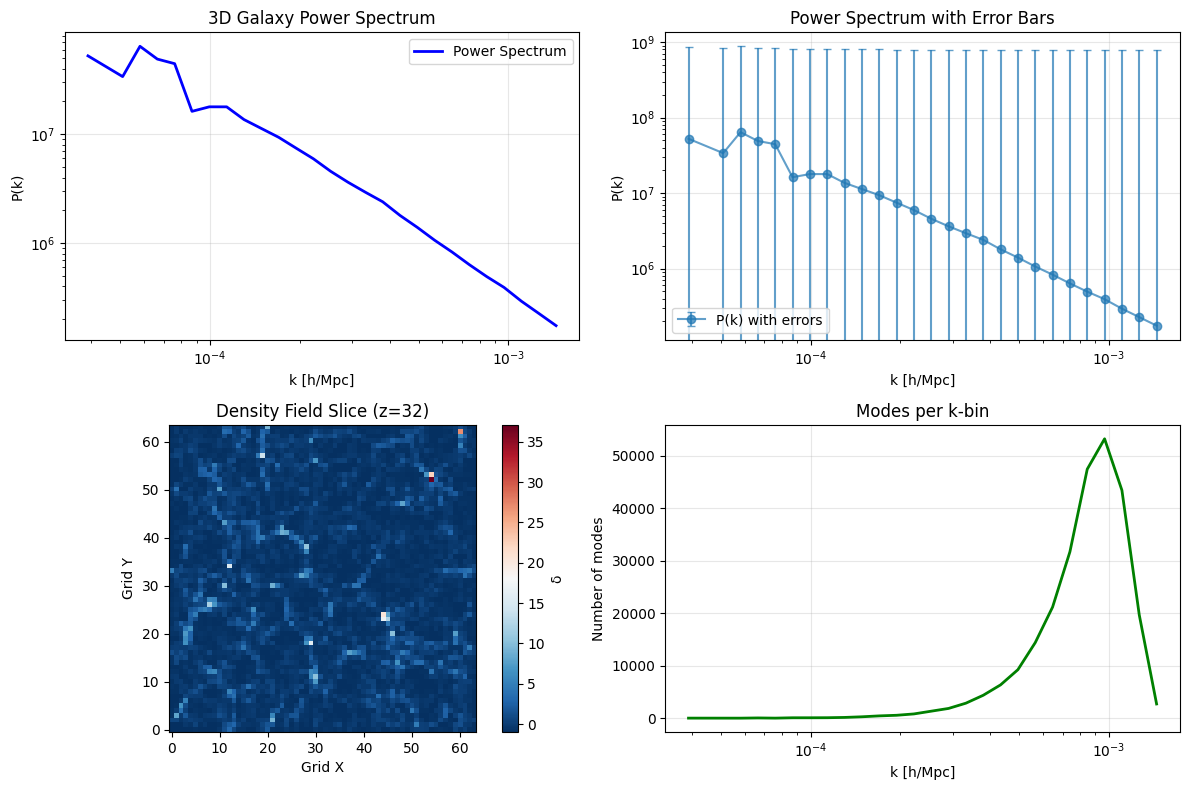


Power Spectrum Statistics:
Number of galaxies: 14485709
Box size: 225500.08
Grid size: 64
Fundamental frequency: 0.0000
Nyquist frequency: 0.0009
Shot noise estimate: 7.9159e+08


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fftn, fftfreq
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

class GalaxyPowerSpectrum:
    def __init__(self, pickle_file_path):
        """
        Initialize the power spectrum calculator with galaxy data
        
        Parameters:
        pickle_file_path (str): Path to the pickle file containing galaxy data
        """
        self.df = pd.read_pickle(pickle_file_path)
        self.positions = None
        self.density_field = None
        self.power_spectrum = None
        self.k_bins = None
        self.power_binned = None
        
        print(f"Loaded {len(self.df)} galaxies")
        print(f"Data columns: {list(self.df.columns)}")
        
        # Analyze the data to understand mass distribution
        self.analyze_data()
        
    def analyze_data(self):
        """
        Analyze the data to understand mass distribution and suggest cuts
        """
        print("\n=== Data Analysis ===")
        
        # Mass statistics
        masses = self.df['SubhaloMass'].values
        valid_masses = masses[masses > 0]  # Remove zero masses
        
        print(f"Mass statistics:")
        print(f"  Total objects: {len(masses)}")
        print(f"  Objects with mass > 0: {len(valid_masses)}")
        print(f"  Mass range: {valid_masses.min():.2e} to {valid_masses.max():.2e}")
        print(f"  Mass median: {np.median(valid_masses):.2e}")
        print(f"  Mass mean: {np.mean(valid_masses):.2e}")
        
        # Mass percentiles
        percentiles = [50, 75, 90, 95, 99]
        print(f"  Mass percentiles:")
        for p in percentiles:
            print(f"    {p}th percentile: {np.percentile(valid_masses, p):.2e}")
        
        # Position statistics
        pos_cols = ['SubhaloPos_0', 'SubhaloPos_1', 'SubhaloPos_2']
        print(f"\nPosition statistics:")
        for i, col in enumerate(pos_cols):
            pos_vals = self.df[col].values
            print(f"  {col}: [{pos_vals.min():.2f}, {pos_vals.max():.2f}], range: {pos_vals.max() - pos_vals.min():.2f}")
        
        # Suggest mass cuts
        print(f"\nSuggested mass cuts:")
        print(f"  For top 50% of galaxies: mass_cut = {np.percentile(valid_masses, 50):.2e}")
        print(f"  For top 25% of galaxies: mass_cut = {np.percentile(valid_masses, 75):.2e}")
        print(f"  For top 10% of galaxies: mass_cut = {np.percentile(valid_masses, 90):.2e}")
        print(f"  For top 5% of galaxies: mass_cut = {np.percentile(valid_masses, 95):.2e}")
        print(f"  For top 1% of galaxies: mass_cut = {np.percentile(valid_masses, 99):.2e}")
        
        return valid_masses
        
    def extract_positions(self, mass_cut=None):
        """
        Extract 3D positions from the dataframe
        
        Parameters:
        mass_cut (float): Optional minimum mass threshold for galaxies
        """
        # Apply mass cut if specified
        if mass_cut is not None:
            mask = self.df['SubhaloMass'] > mass_cut
            df_filtered = self.df[mask]
            print(f"Applied mass cut > {mass_cut:.2e}: {len(df_filtered)} galaxies remaining")
        else:
            df_filtered = self.df
            print(f"No mass cut applied: {len(df_filtered)} galaxies")
            
        # Check if we have any galaxies left
        if len(df_filtered) == 0:
            print("ERROR: No galaxies remain after mass cut!")
            print("Please use a lower mass_cut value. See suggested values above.")
            return None
            
        # Extract positions
        self.positions = np.column_stack([
            df_filtered['SubhaloPos_0'].values,
            df_filtered['SubhaloPos_1'].values,
            df_filtered['SubhaloPos_2'].values
        ])
        
        print(f"Position range:")
        print(f"  X: [{self.positions[:, 0].min():.2f}, {self.positions[:, 0].max():.2f}]")
        print(f"  Y: [{self.positions[:, 1].min():.2f}, {self.positions[:, 1].max():.2f}]")
        print(f"  Z: [{self.positions[:, 2].min():.2f}, {self.positions[:, 2].max():.2f}]")
        
        return self.positions
    
    def create_density_field(self, grid_size=128, box_size=None):
        """
        Create a 3D density field from galaxy positions using NGP (Nearest Grid Point)
        
        Parameters:
        grid_size (int): Number of grid points per dimension
        box_size (float): Physical size of the simulation box. If None, inferred from data
        """
        if self.positions is None:
            raise ValueError("Must extract positions first using extract_positions()")
            
        # Determine box size
        if box_size is None:
            # Use the range of positions with some padding
            ranges = self.positions.max(axis=0) - self.positions.min(axis=0)
            box_size = ranges.max() * 1.1  # Add 10% padding
            print(f"Inferred box size: {box_size:.2f}")
        
        self.box_size = box_size
        self.grid_size = grid_size
        
        # Create 3D grid
        self.density_field = np.zeros((grid_size, grid_size, grid_size))
        
        # Convert positions to grid indices
        # Shift positions to be positive and scale to grid
        pos_shifted = self.positions - self.positions.min(axis=0)
        pos_scaled = pos_shifted * (grid_size - 1) / (pos_shifted.max(axis=0))
        
        # Use NGP assignment
        indices = np.round(pos_scaled).astype(int)
        
        # Ensure indices are within bounds
        indices = np.clip(indices, 0, grid_size - 1)
        
        # Assign galaxies to grid
        for i in range(len(indices)):
            x, y, z = indices[i]
            self.density_field[x, y, z] += 1
        
        # Convert to density contrast
        mean_density = np.mean(self.density_field)
        self.density_field = (self.density_field - mean_density) / mean_density
        
        print(f"Created {grid_size}^3 density field")
        print(f"Mean density: {mean_density:.4f}")
        print(f"Density contrast range: [{self.density_field.min():.4f}, {self.density_field.max():.4f}]")
        
        return self.density_field
    
    def compute_power_spectrum(self):
        """
        Compute the 3D power spectrum from the density field
        """
        if self.density_field is None:
            raise ValueError("Must create density field first using create_density_field()")
            
        # Compute 3D FFT
        fft_field = fftn(self.density_field)
        
        # Compute power spectrum (|FFT|^2)
        power_3d = np.abs(fft_field)**2
        
        # Create frequency arrays
        kx = fftfreq(self.grid_size, d=self.box_size/self.grid_size) * 2 * np.pi
        ky = fftfreq(self.grid_size, d=self.box_size/self.grid_size) * 2 * np.pi
        kz = fftfreq(self.grid_size, d=self.box_size/self.grid_size) * 2 * np.pi
        
        # Create 3D k-magnitude array
        kx_3d, ky_3d, kz_3d = np.meshgrid(kx, ky, kz, indexing='ij')
        k_mag = np.sqrt(kx_3d**2 + ky_3d**2 + kz_3d**2)
        
        # Avoid k=0 mode
        k_mag[0, 0, 0] = np.inf
        
        self.k_mag = k_mag
        self.power_3d = power_3d
        
        return power_3d, k_mag
    
    def bin_power_spectrum(self, n_bins=50, k_min=None, k_max=None):
        """
        Bin the 3D power spectrum in spherical shells
        
        Parameters:
        n_bins (int): Number of k-bins
        k_min, k_max (float): Min and max k values. If None, determined from data
        """
        if self.power_3d is None:
            raise ValueError("Must compute power spectrum first using compute_power_spectrum()")
            
        # Flatten arrays
        k_flat = self.k_mag.flatten()
        power_flat = self.power_3d.flatten()
        
        # Remove k=0 and invalid values
        valid_mask = (k_flat > 0) & (k_flat != np.inf) & np.isfinite(power_flat)
        k_valid = k_flat[valid_mask]
        power_valid = power_flat[valid_mask]
        
        # Set k range
        if k_min is None:
            k_min = k_valid.min()
        if k_max is None:
            k_max = k_valid.max()
            
        # Create logarithmic bins
        k_edges = np.logspace(np.log10(k_min), np.log10(k_max), n_bins + 1)
        k_centers = np.sqrt(k_edges[:-1] * k_edges[1:])  # Geometric mean
        
        # Bin the power spectrum
        power_binned = np.zeros(n_bins)
        k_counts = np.zeros(n_bins)
        
        for i in range(n_bins):
            mask = (k_valid >= k_edges[i]) & (k_valid < k_edges[i+1])
            if np.sum(mask) > 0:
                power_binned[i] = np.mean(power_valid[mask])
                k_counts[i] = np.sum(mask)
        
        # Only keep bins with data
        valid_bins = k_counts > 0
        self.k_bins = k_centers[valid_bins]
        self.power_binned = power_binned[valid_bins]
        self.k_counts = k_counts[valid_bins]
        
        print(f"Binned power spectrum into {len(self.k_bins)} k-bins")
        print(f"k range: [{self.k_bins.min():.4f}, {self.k_bins.max():.4f}]")
        
        return self.k_bins, self.power_binned
    
    def plot_power_spectrum(self, figsize=(12, 8)):
        """
        Plot the power spectrum and related diagnostics
        """
        if self.k_bins is None or self.power_binned is None:
            raise ValueError("Must bin power spectrum first using bin_power_spectrum()")
            
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Main power spectrum plot
        ax1 = axes[0, 0]
        ax1.loglog(self.k_bins, self.power_binned, 'b-', linewidth=2, label='Power Spectrum')
        ax1.set_xlabel('k [h/Mpc]')
        ax1.set_ylabel('P(k)')
        ax1.set_title('3D Galaxy Power Spectrum')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Power spectrum with error estimate
        ax2 = axes[0, 1]
        # Rough error estimate from shot noise
        shot_noise = 1.0 / len(self.positions) * (self.box_size**3)
        errors = self.power_binned / np.sqrt(self.k_counts) + shot_noise
        
        ax2.errorbar(self.k_bins, self.power_binned, yerr=errors, 
                    fmt='o-', capsize=3, alpha=0.7, label='P(k) with errors')
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax2.set_xlabel('k [h/Mpc]')
        ax2.set_ylabel('P(k)')
        ax2.set_title('Power Spectrum with Error Bars')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Density field slice
        ax3 = axes[1, 0]
        if self.density_field is not None:
            slice_z = self.grid_size // 2
            im = ax3.imshow(self.density_field[:, :, slice_z], 
                           cmap='RdBu_r', origin='lower')
            ax3.set_title(f'Density Field Slice (z={slice_z})')
            ax3.set_xlabel('Grid X')
            ax3.set_ylabel('Grid Y')
            plt.colorbar(im, ax=ax3, label='δ')
        
        # Mode count per k-bin
        ax4 = axes[1, 1]
        ax4.semilogx(self.k_bins, self.k_counts, 'g-', linewidth=2)
        ax4.set_xlabel('k [h/Mpc]')
        ax4.set_ylabel('Number of modes')
        ax4.set_title('Modes per k-bin')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print some statistics
        print("\nPower Spectrum Statistics:")
        print(f"Number of galaxies: {len(self.positions)}")
        print(f"Box size: {self.box_size:.2f}")
        print(f"Grid size: {self.grid_size}")
        print(f"Fundamental frequency: {2*np.pi/self.box_size:.4f}")
        print(f"Nyquist frequency: {np.pi*self.grid_size/self.box_size:.4f}")
        print(f"Shot noise estimate: {shot_noise:.4e}")
    
    def run_full_analysis(self, mass_cut=None, grid_size=128, n_bins=50):
        """
        Run the complete power spectrum analysis
        
        Parameters:
        mass_cut (float): Optional minimum mass threshold
        grid_size (int): Grid resolution for density field
        n_bins (int): Number of k-bins for power spectrum
        """
        print("=== Galaxy Power Spectrum Analysis ===\n")
        
        # Step 1: Extract positions
        print("1. Extracting galaxy positions...")
        positions = self.extract_positions(mass_cut=mass_cut)
        
        if positions is None:
            print("Analysis stopped due to no galaxies remaining after mass cut.")
            return None, None
        
        # Step 2: Create density field
        print("\n2. Creating density field...")
        self.create_density_field(grid_size=grid_size)
        
        # Step 3: Compute power spectrum
        print("\n3. Computing 3D power spectrum...")
        self.compute_power_spectrum()
        
        # Step 4: Bin power spectrum
        print("\n4. Binning power spectrum...")
        self.bin_power_spectrum(n_bins=n_bins)
        
        # Step 5: Plot results
        print("\n5. Plotting results...")
        self.plot_power_spectrum()
        
        return self.k_bins, self.power_binned

# Example usage:
if __name__ == "__main__":
    # Initialize the analyzer
    file_path = '/gpfs/nchugh/groupcat_data/subhalos_snap_99.pkl'
    
    # Create analyzer instance - this will show data statistics
    analyzer = GalaxyPowerSpectrum(file_path)
    
    # First, let's see what mass cuts make sense
    print("\n" + "="*50)
    print("RECOMMENDATION: Start with a conservative mass cut based on the analysis above.")
    print("For example, try using the 90th percentile mass as your cut.")
    print("="*50)
    
    # Run analysis with no mass cut first to see all galaxies
    print("\n>>> Running analysis with NO mass cut (all galaxies):")
    k_bins, power_spectrum = analyzer.run_full_analysis(
        mass_cut=None,     # No mass cut
        grid_size=64,      # Smaller grid for speed with all galaxies
        n_bins=30          # Fewer bins for speed
    )
    
    # Then try with a reasonable mass cut
    # You can uncomment and adjust this based on the statistics shown above:
    
    # print("\n>>> Running analysis with mass cut at 90th percentile:")
    # mass_90th = # Use the value from the analysis above
    # k_bins, power_spectrum = analyzer.run_full_analysis(
    #     mass_cut=mass_90th,
    #     grid_size=128,
    #     n_bins=40
    # )

Loaded 14485709 galaxies
Data columns: ['SubhaloFlag', 'SubhaloMass', 'SubhaloSFR', 'SubhaloParent', 'SubhaloPos_0', 'SubhaloPos_1', 'SubhaloPos_2', 'SubhaloStarMetallicity', 'SubhaloGasMetallicity', 'SubhaloMassStars', 'SubhaloMassBH', 'SubhaloVel_0', 'SubhaloVel_1', 'SubhaloVel_2', 'SubhaloVelDisp', 'SubhaloGrNr', 'SubhaloVmax', 'SubhaloSpin_0', 'SubhaloSpin_1', 'SubhaloSpin_2', 'Redshift']

=== Data Analysis ===
Mass statistics:
  Total objects: 14485709
  Objects with mass > 0: 14485709
  Mass range: 6.46e-03 to 1.28e+05
  Mass median: 2.24e-01
  Mass mean: 2.32e+00
  Mass percentiles:
    50th percentile: 2.24e-01
    75th percentile: 5.18e-01
    90th percentile: 1.55e+00
    95th percentile: 3.35e+00
    99th percentile: 2.14e+01

Position statistics:
  SubhaloPos_0: [-0.09, 204999.97], range: 205000.06
  SubhaloPos_1: [0.01, 205000.00], range: 205000.00
  SubhaloPos_2: [0.02, 204999.98], range: 204999.97

Suggested mass cuts:
  For top 50% of galaxies: mass_cut = 2.24e-01
  For

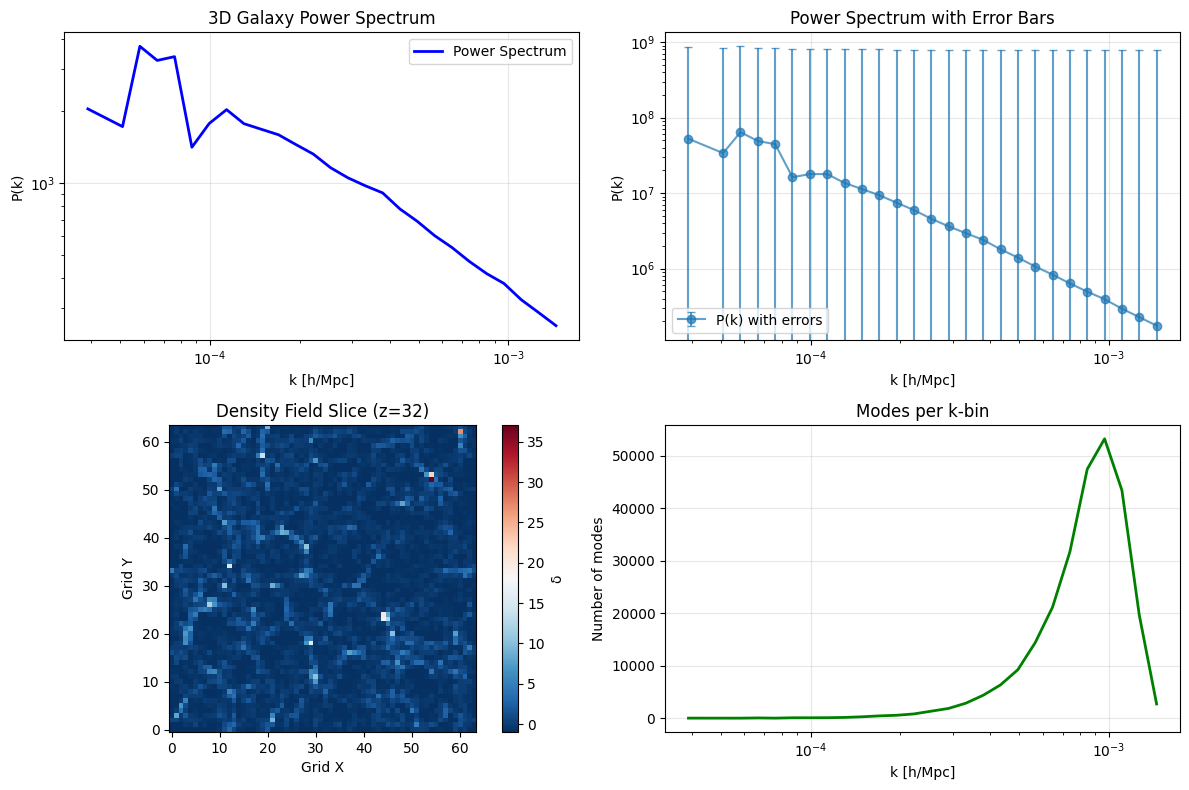


Power Spectrum Statistics:
Number of galaxies: 14485709
Box size: 225500.08
Grid size: 64
Fundamental frequency: 0.0000
Nyquist frequency: 0.0009
Shot noise estimate: 7.9159e+08


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fftn, fftfreq
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

class GalaxyPowerSpectrum:
    def __init__(self, pickle_file_path):
        """
        Initialize the power spectrum calculator with galaxy data
        
        Parameters:
        pickle_file_path (str): Path to the pickle file containing galaxy data
        """
        self.df = pd.read_pickle(pickle_file_path)
        self.positions = None
        self.density_field = None
        self.power_spectrum = None
        self.k_bins = None
        self.power_binned = None
        
        print(f"Loaded {len(self.df)} galaxies")
        print(f"Data columns: {list(self.df.columns)}")
        
        # Analyze the data to understand mass distribution
        self.analyze_data()
        
    def analyze_data(self):
        """
        Analyze the data to understand mass distribution and suggest cuts
        """
        print("\n=== Data Analysis ===")
        
        # Mass statistics
        masses = self.df['SubhaloMass'].values
        valid_masses = masses[masses > 0]  # Remove zero masses
        
        print(f"Mass statistics:")
        print(f"  Total objects: {len(masses)}")
        print(f"  Objects with mass > 0: {len(valid_masses)}")
        print(f"  Mass range: {valid_masses.min():.2e} to {valid_masses.max():.2e}")
        print(f"  Mass median: {np.median(valid_masses):.2e}")
        print(f"  Mass mean: {np.mean(valid_masses):.2e}")
        
        # Mass percentiles
        percentiles = [50, 75, 90, 95, 99]
        print(f"  Mass percentiles:")
        for p in percentiles:
            print(f"    {p}th percentile: {np.percentile(valid_masses, p):.2e}")
        
        # Position statistics
        pos_cols = ['SubhaloPos_0', 'SubhaloPos_1', 'SubhaloPos_2']
        print(f"\nPosition statistics:")
        for i, col in enumerate(pos_cols):
            pos_vals = self.df[col].values
            print(f"  {col}: [{pos_vals.min():.2f}, {pos_vals.max():.2f}], range: {pos_vals.max() - pos_vals.min():.2f}")
        
        # Suggest mass cuts
        print(f"\nSuggested mass cuts:")
        print(f"  For top 50% of galaxies: mass_cut = {np.percentile(valid_masses, 50):.2e}")
        print(f"  For top 25% of galaxies: mass_cut = {np.percentile(valid_masses, 75):.2e}")
        print(f"  For top 10% of galaxies: mass_cut = {np.percentile(valid_masses, 90):.2e}")
        print(f"  For top 5% of galaxies: mass_cut = {np.percentile(valid_masses, 95):.2e}")
        print(f"  For top 1% of galaxies: mass_cut = {np.percentile(valid_masses, 99):.2e}")
        
        return valid_masses
        
    def extract_positions(self, mass_cut=None):
        """
        Extract 3D positions from the dataframe
        
        Parameters:
        mass_cut (float): Optional minimum mass threshold for galaxies
        """
        # Apply mass cut if specified
        if mass_cut is not None:
            mask = self.df['SubhaloMass'] > mass_cut
            df_filtered = self.df[mask]
            print(f"Applied mass cut > {mass_cut:.2e}: {len(df_filtered)} galaxies remaining")
        else:
            df_filtered = self.df
            print(f"No mass cut applied: {len(df_filtered)} galaxies")
            
        # Check if we have any galaxies left
        if len(df_filtered) == 0:
            print("ERROR: No galaxies remain after mass cut!")
            print("Please use a lower mass_cut value. See suggested values above.")
            return None
            
        # Extract positions
        self.positions = np.column_stack([
            df_filtered['SubhaloPos_0'].values,
            df_filtered['SubhaloPos_1'].values,
            df_filtered['SubhaloPos_2'].values
        ])
        
        print(f"Position range:")
        print(f"  X: [{self.positions[:, 0].min():.2f}, {self.positions[:, 0].max():.2f}]")
        print(f"  Y: [{self.positions[:, 1].min():.2f}, {self.positions[:, 1].max():.2f}]")
        print(f"  Z: [{self.positions[:, 2].min():.2f}, {self.positions[:, 2].max():.2f}]")
        
        return self.positions
    
    def create_density_field(self, grid_size=128, box_size=None):
        """
        Create a 3D density field from galaxy positions using NGP (Nearest Grid Point)
        
        Parameters:
        grid_size (int): Number of grid points per dimension
        box_size (float): Physical size of the simulation box. If None, inferred from data
        """
        if self.positions is None:
            raise ValueError("Must extract positions first using extract_positions()")
            
        # Determine box size
        if box_size is None:
            # Use the range of positions with some padding
            ranges = self.positions.max(axis=0) - self.positions.min(axis=0)
            box_size = ranges.max() * 1.1  # Add 10% padding
            print(f"Inferred box size: {box_size:.2f}")
        
        self.box_size = box_size
        self.grid_size = grid_size
        
        # Create 3D grid
        self.density_field = np.zeros((grid_size, grid_size, grid_size))
        
        # Convert positions to grid indices
        # Shift positions to be positive and scale to grid
        pos_shifted = self.positions - self.positions.min(axis=0)
        pos_scaled = pos_shifted * (grid_size - 1) / (pos_shifted.max(axis=0))
        
        # Use NGP assignment
        indices = np.round(pos_scaled).astype(int)
        
        # Ensure indices are within bounds
        indices = np.clip(indices, 0, grid_size - 1)
        
        # Assign galaxies to grid
        for i in range(len(indices)):
            x, y, z = indices[i]
            self.density_field[x, y, z] += 1
        
        # Convert to density contrast
        mean_density = np.mean(self.density_field)
        self.density_field = (self.density_field - mean_density) / mean_density
        
        print(f"Created {grid_size}^3 density field")
        print(f"Mean density: {mean_density:.4f}")
        print(f"Density contrast range: [{self.density_field.min():.4f}, {self.density_field.max():.4f}]")
        
        return self.density_field
    
    def compute_power_spectrum(self):
        """
        Compute the 3D power spectrum from the density field
        """
        if self.density_field is None:
            raise ValueError("Must create density field first using create_density_field()")
            
        # Compute 3D FFT
        fft_field = fftn(self.density_field)
        
        # Compute power spectrum (|FFT|^2)
        power_3d = np.abs(fft_field)**2
        
        # Create frequency arrays
        kx = fftfreq(self.grid_size, d=self.box_size/self.grid_size) * 2 * np.pi
        ky = fftfreq(self.grid_size, d=self.box_size/self.grid_size) * 2 * np.pi
        kz = fftfreq(self.grid_size, d=self.box_size/self.grid_size) * 2 * np.pi
        
        # Create 3D k-magnitude array
        kx_3d, ky_3d, kz_3d = np.meshgrid(kx, ky, kz, indexing='ij')
        k_mag = np.sqrt(kx_3d**2 + ky_3d**2 + kz_3d**2)
        
        # Avoid k=0 mode
        k_mag[0, 0, 0] = np.inf
        
        self.k_mag = k_mag
        self.power_3d = power_3d
        
        return power_3d, k_mag
    
    def bin_power_spectrum(self, n_bins=50, k_min=None, k_max=None):
        """
        Bin the 3D power spectrum in spherical shells
        
        Parameters:
        n_bins (int): Number of k-bins
        k_min, k_max (float): Min and max k values. If None, determined from data
        """
        if self.power_3d is None:
            raise ValueError("Must compute power spectrum first using compute_power_spectrum()")
            
        # Flatten arrays
        k_flat = self.k_mag.flatten()
        power_flat = self.power_3d.flatten()
        
        # Remove k=0 and invalid values
        valid_mask = (k_flat > 0) & (k_flat != np.inf) & np.isfinite(power_flat)
        k_valid = k_flat[valid_mask]
        power_valid = power_flat[valid_mask]
        
        # Set k range
        if k_min is None:
            k_min = k_valid.min()
        if k_max is None:
            k_max = k_valid.max()
            
        # Create logarithmic bins
        k_edges = np.logspace(np.log10(k_min), np.log10(k_max), n_bins + 1)
        k_centers = np.sqrt(k_edges[:-1] * k_edges[1:])  # Geometric mean
        
        # Bin the power spectrum
        power_binned = np.zeros(n_bins)
        k_counts = np.zeros(n_bins)
        
        for i in range(n_bins):
            mask = (k_valid >= k_edges[i]) & (k_valid < k_edges[i+1])
            if np.sum(mask) > 0:
                power_binned[i] = np.mean(power_valid[mask])
                k_counts[i] = np.sum(mask)
        
        # Only keep bins with data
        valid_bins = k_counts > 0
        self.k_bins = k_centers[valid_bins]
        self.power_binned = power_binned[valid_bins]
        self.k_counts = k_counts[valid_bins]
        
        print(f"Binned power spectrum into {len(self.k_bins)} k-bins")
        print(f"k range: [{self.k_bins.min():.4f}, {self.k_bins.max():.4f}]")
        
        return self.k_bins, self.power_binned
    
    def plot_power_spectrum(self, figsize=(12, 8)):
        """
        Plot the power spectrum and related diagnostics
        """
        if self.k_bins is None or self.power_binned is None:
            raise ValueError("Must bin power spectrum first using bin_power_spectrum()")
            
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Main power spectrum plot
        ax1 = axes[0, 0]
        ax1.loglog(self.k_bins, self.k_bins*self.power_binned, 'b-', linewidth=2, label='Power Spectrum')
        ax1.set_xlabel('k [h/Mpc]')
        ax1.set_ylabel('P(k)')
        ax1.set_title('3D Galaxy Power Spectrum')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Power spectrum with error estimate
        ax2 = axes[0, 1]
        # Rough error estimate from shot noise
        shot_noise = 1.0 / len(self.positions) * (self.box_size**3)
        errors = self.power_binned / np.sqrt(self.k_counts) + shot_noise
        
        ax2.errorbar(self.k_bins, self.power_binned, yerr=errors, 
                    fmt='o-', capsize=3, alpha=0.7, label='P(k) with errors')
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax2.set_xlabel('k [h/Mpc]')
        ax2.set_ylabel('P(k)')
        ax2.set_title('Power Spectrum with Error Bars')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Density field slice
        ax3 = axes[1, 0]
        if self.density_field is not None:
            slice_z = self.grid_size // 2
            im = ax3.imshow(self.density_field[:, :, slice_z], 
                           cmap='RdBu_r', origin='lower')
            ax3.set_title(f'Density Field Slice (z={slice_z})')
            ax3.set_xlabel('Grid X')
            ax3.set_ylabel('Grid Y')
            plt.colorbar(im, ax=ax3, label='δ')
        
        # Mode count per k-bin
        ax4 = axes[1, 1]
        ax4.semilogx(self.k_bins, self.k_counts, 'g-', linewidth=2)
        ax4.set_xlabel('k [h/Mpc]')
        ax4.set_ylabel('Number of modes')
        ax4.set_title('Modes per k-bin')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print some statistics
        print("\nPower Spectrum Statistics:")
        print(f"Number of galaxies: {len(self.positions)}")
        print(f"Box size: {self.box_size:.2f}")
        print(f"Grid size: {self.grid_size}")
        print(f"Fundamental frequency: {2*np.pi/self.box_size:.4f}")
        print(f"Nyquist frequency: {np.pi*self.grid_size/self.box_size:.4f}")
        print(f"Shot noise estimate: {shot_noise:.4e}")
    
    def run_full_analysis(self, mass_cut=None, grid_size=128, n_bins=50):
        """
        Run the complete power spectrum analysis
        
        Parameters:
        mass_cut (float): Optional minimum mass threshold
        grid_size (int): Grid resolution for density field
        n_bins (int): Number of k-bins for power spectrum
        """
        print("=== Galaxy Power Spectrum Analysis ===\n")
        
        # Step 1: Extract positions
        print("1. Extracting galaxy positions...")
        positions = self.extract_positions(mass_cut=mass_cut)
        
        if positions is None:
            print("Analysis stopped due to no galaxies remaining after mass cut.")
            return None, None
        
        # Step 2: Create density field
        print("\n2. Creating density field...")
        self.create_density_field(grid_size=grid_size)
        
        # Step 3: Compute power spectrum
        print("\n3. Computing 3D power spectrum...")
        self.compute_power_spectrum()
        
        # Step 4: Bin power spectrum
        print("\n4. Binning power spectrum...")
        self.bin_power_spectrum(n_bins=n_bins)
        
        # Step 5: Plot results
        print("\n5. Plotting results...")
        self.plot_power_spectrum()
        
        return self.k_bins, self.power_binned

# Example usage:
if __name__ == "__main__":
    # Initialize the analyzer
    file_path = '/gpfs/nchugh/groupcat_data/subhalos_snap_99.pkl'
    
    # Create analyzer instance - this will show data statistics
    analyzer = GalaxyPowerSpectrum(file_path)
    
    # First, let's see what mass cuts make sense
    print("\n" + "="*50)
    print("RECOMMENDATION: Start with a conservative mass cut based on the analysis above.")
    print("For example, try using the 90th percentile mass as your cut.")
    print("="*50)
    
    # Run analysis with no mass cut first to see all galaxies
    print("\n>>> Running analysis with NO mass cut (all galaxies):")
    k_bins, power_spectrum = analyzer.run_full_analysis(
        mass_cut=None,     # No mass cut
        grid_size=64,      # Smaller grid for speed with all galaxies
        n_bins=30          # Fewer bins for speed
    )
    
    # Then try with a reasonable mass cut
    # You can uncomment and adjust this based on the statistics shown above:
    
    # print("\n>>> Running analysis with mass cut at 90th percentile:")
    # mass_90th = # Use the value from the analysis above
    # k_bins, power_spectrum = analyzer.run_full_analysis(
    #     mass_cut=mass_90th,
    #     grid_size=128,
    #     n_bins=40
    # )

Loaded 14485709 galaxies

=== Data Analysis ===
SFR statistics:
  Total objects: 14485709
  Star-forming objects (SFR > 0): 576947
  Fraction star-forming: 0.040
  SFR range: 7.87e-04 to 5.92e+01
  SFR median: 4.94e-02
  SFR mean: 2.97e-01

Mass statistics (star-forming galaxies only):
  Mass range: 1.21e-02 to 8.87e+04
  Mass median: 8.26e+00
  Mass mean: 3.16e+01

Running analysis with all star-forming galaxies:
=== Mean Subhalo Mass vs SFR Analysis ===

Binning results:
  Total star-forming galaxies: 576947
  SFR bins with data: 25/25
  SFR range: 9.85e-04 to 4.73e+01


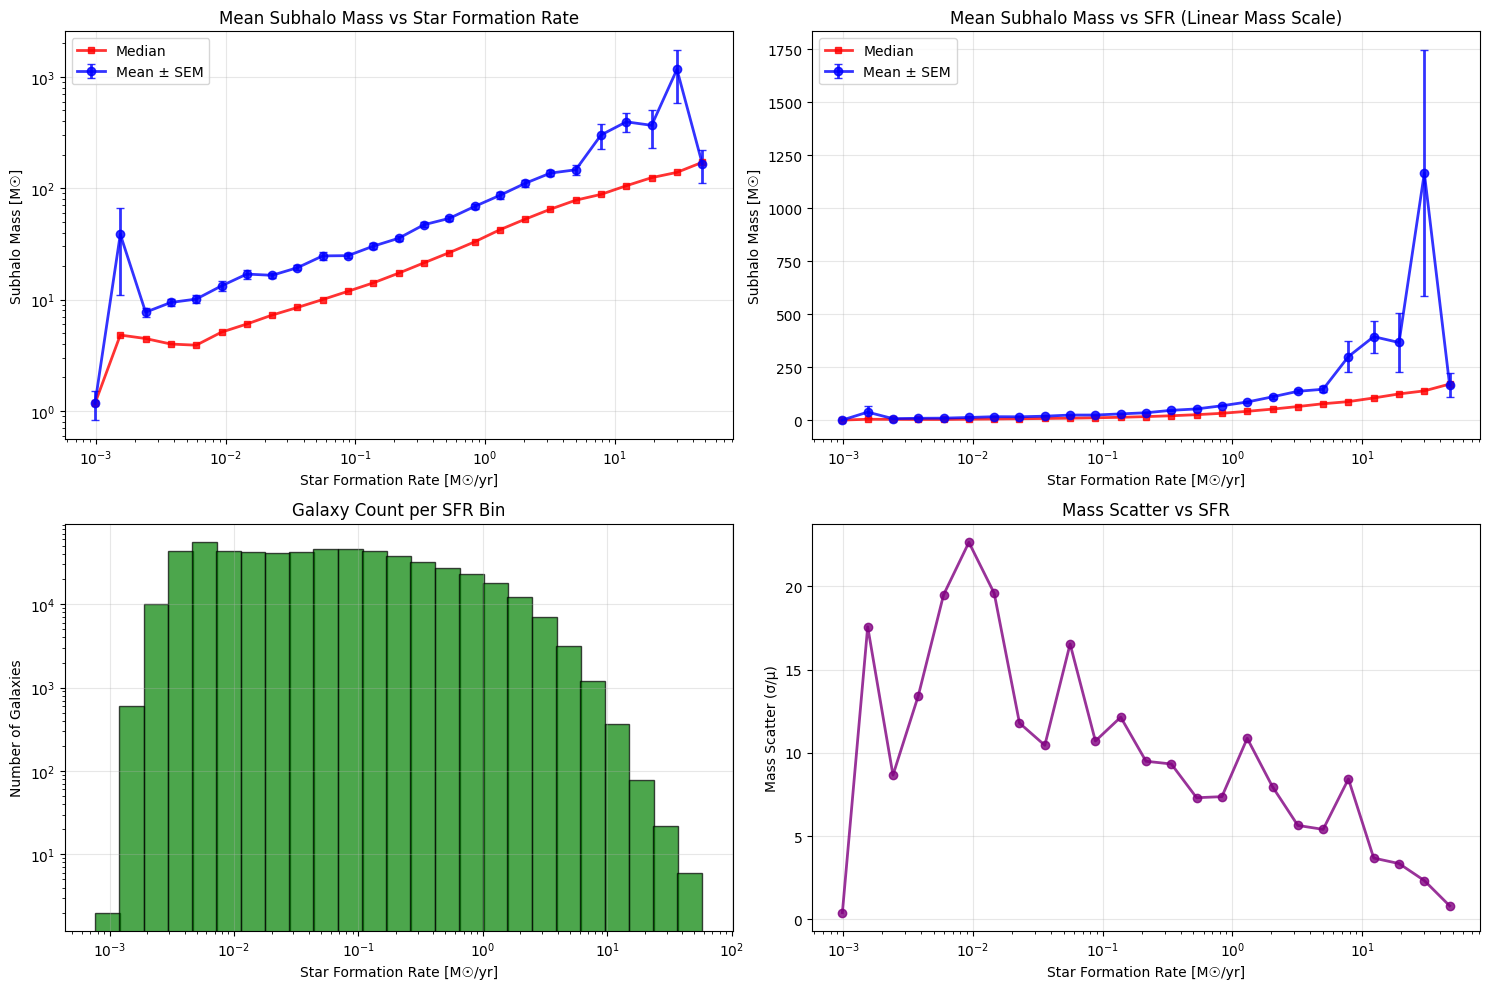


=== Mass-SFR Relationship Statistics ===
Total star-forming galaxies: 576947
SFR range: 9.85e-04 to 4.73e+01 M☉/yr
Mass range: 1.17e+00 to 1.17e+03 M☉
Log-log correlation coefficient: 0.918 (p = 9.83e-11)
Power law fit: M ∝ SFR^0.42 (R² = 0.843)


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class MassSFRAnalyzer:
    def __init__(self, pickle_file_path):
        """
        Initialize the mass-SFR analyzer
        
        Parameters:
        pickle_file_path (str): Path to the pickle file containing galaxy data
        """
        self.df = pd.read_pickle(pickle_file_path)
        print(f"Loaded {len(self.df)} galaxies")
        
        # Analyze the data
        self.analyze_data()
        
    def analyze_data(self):
        """
        Analyze the SFR and mass distributions
        """
        print("\n=== Data Analysis ===")
        
        # SFR statistics
        sfr_vals = self.df['SubhaloSFR'].values
        valid_sfr = sfr_vals[sfr_vals > 0]  # Only star-forming galaxies
        
        print(f"SFR statistics:")
        print(f"  Total objects: {len(sfr_vals)}")
        print(f"  Star-forming objects (SFR > 0): {len(valid_sfr)}")
        print(f"  Fraction star-forming: {len(valid_sfr)/len(sfr_vals):.3f}")
        if len(valid_sfr) > 0:
            print(f"  SFR range: {valid_sfr.min():.2e} to {valid_sfr.max():.2e}")
            print(f"  SFR median: {np.median(valid_sfr):.2e}")
            print(f"  SFR mean: {np.mean(valid_sfr):.2e}")
        
        # Mass statistics for star-forming galaxies
        star_forming_mask = sfr_vals > 0
        masses_sf = self.df[star_forming_mask]['SubhaloMass'].values
        valid_masses_sf = masses_sf[masses_sf > 0]
        
        print(f"\nMass statistics (star-forming galaxies only):")
        if len(valid_masses_sf) > 0:
            print(f"  Mass range: {valid_masses_sf.min():.2e} to {valid_masses_sf.max():.2e}")
            print(f"  Mass median: {np.median(valid_masses_sf):.2e}")
            print(f"  Mass mean: {np.mean(valid_masses_sf):.2e}")
        
    def create_sfr_bins(self, n_bins=20, sfr_min=None, sfr_max=None, log_bins=True):
        """
        Create SFR bins for analysis
        
        Parameters:
        n_bins (int): Number of SFR bins
        sfr_min, sfr_max (float): SFR range. If None, determined from data
        log_bins (bool): Use logarithmic binning
        """
        # Get star-forming galaxies only
        star_forming = self.df[self.df['SubhaloSFR'] > 0].copy()
        
        if len(star_forming) == 0:
            print("No star-forming galaxies found!")
            return None, None, None
            
        sfr_vals = star_forming['SubhaloSFR'].values
        
        # Set SFR range
        if sfr_min is None:
            sfr_min = sfr_vals.min()
        if sfr_max is None:
            sfr_max = sfr_vals.max()
            
        # Create bins
        if log_bins:
            # Logarithmic bins
            sfr_edges = np.logspace(np.log10(sfr_min), np.log10(sfr_max), n_bins + 1)
            sfr_centers = np.sqrt(sfr_edges[:-1] * sfr_edges[1:])  # Geometric mean
        else:
            # Linear bins
            sfr_edges = np.linspace(sfr_min, sfr_max, n_bins + 1)
            sfr_centers = 0.5 * (sfr_edges[:-1] + sfr_edges[1:])  # Arithmetic mean
            
        return star_forming, sfr_edges, sfr_centers
    
    def compute_mean_mass_vs_sfr(self, n_bins=20, sfr_min=None, sfr_max=None, 
                                log_bins=True, mass_min=0):
        """
        Compute mean subhalo mass as a function of SFR
        
        Parameters:
        n_bins (int): Number of SFR bins
        sfr_min, sfr_max (float): SFR range
        log_bins (bool): Use logarithmic binning
        mass_min (float): Minimum mass threshold
        """
        # Get star-forming galaxies
        star_forming, sfr_edges, sfr_centers = self.create_sfr_bins(
            n_bins, sfr_min, sfr_max, log_bins)
        
        if star_forming is None:
            return None
            
        # Apply mass cut
        if mass_min > 0:
            star_forming = star_forming[star_forming['SubhaloMass'] > mass_min]
            print(f"Applied mass cut > {mass_min:.2e}: {len(star_forming)} galaxies remaining")
        
        # Initialize arrays for results
        mean_masses = np.zeros(len(sfr_centers))
        std_masses = np.zeros(len(sfr_centers))
        median_masses = np.zeros(len(sfr_centers))
        counts = np.zeros(len(sfr_centers))
        
        # Calculate statistics for each SFR bin
        for i in range(len(sfr_centers)):
            mask = ((star_forming['SubhaloSFR'] >= sfr_edges[i]) & 
                   (star_forming['SubhaloSFR'] < sfr_edges[i+1]))
            
            masses_in_bin = star_forming[mask]['SubhaloMass'].values
            
            if len(masses_in_bin) > 0:
                mean_masses[i] = np.mean(masses_in_bin)
                std_masses[i] = np.std(masses_in_bin)
                median_masses[i] = np.median(masses_in_bin)
                counts[i] = len(masses_in_bin)
            else:
                mean_masses[i] = np.nan
                std_masses[i] = np.nan
                median_masses[i] = np.nan
                counts[i] = 0
        
        # Remove empty bins
        valid_bins = counts > 0
        
        results = {
            'sfr_centers': sfr_centers[valid_bins],
            'sfr_edges': sfr_edges,
            'mean_masses': mean_masses[valid_bins],
            'std_masses': std_masses[valid_bins],
            'median_masses': median_masses[valid_bins],
            'counts': counts[valid_bins],
            'total_galaxies': len(star_forming)
        }
        
        print(f"\nBinning results:")
        print(f"  Total star-forming galaxies: {len(star_forming)}")
        print(f"  SFR bins with data: {np.sum(valid_bins)}/{len(sfr_centers)}")
        print(f"  SFR range: {sfr_centers[valid_bins].min():.2e} to {sfr_centers[valid_bins].max():.2e}")
        
        return results
    
    def plot_mass_vs_sfr(self, results=None, n_bins=20, sfr_min=None, sfr_max=None, 
                        log_bins=True, mass_min=0, figsize=(15, 10)):
        """
        Plot mean subhalo mass as a function of SFR
        
        Parameters:
        results (dict): Pre-computed results. If None, will compute
        Other parameters: Same as compute_mean_mass_vs_sfr
        figsize (tuple): Figure size
        """
        # Compute results if not provided
        if results is None:
            results = self.compute_mean_mass_vs_sfr(n_bins, sfr_min, sfr_max, 
                                                  log_bins, mass_min)
        
        if results is None:
            print("No data to plot!")
            return
        
        # Create figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        sfr_centers = results['sfr_centers']
        mean_masses = results['mean_masses']
        std_masses = results['std_masses']
        median_masses = results['median_masses']
        counts = results['counts']
        
        # Plot 1: Mean mass vs SFR with error bars
        ax1 = axes[0, 0]
        ax1.errorbar(sfr_centers, mean_masses, yerr=std_masses/np.sqrt(counts),
                    fmt='o-', capsize=3, capthick=1, linewidth=2, markersize=6,
                    label='Mean ± SEM', color='blue', alpha=0.8)
        ax1.plot(sfr_centers, median_masses, 's-', linewidth=2, markersize=5,
                label='Median', color='red', alpha=0.8)
        
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.set_xlabel('Star Formation Rate [M☉/yr]')
        ax1.set_ylabel('Subhalo Mass [M☉]')
        ax1.set_title('Mean Subhalo Mass vs Star Formation Rate')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Plot 2: Same but linear scale for mass
        ax2 = axes[0, 1]
        ax2.errorbar(sfr_centers, mean_masses, yerr=std_masses/np.sqrt(counts),
                    fmt='o-', capsize=3, capthick=1, linewidth=2, markersize=6,
                    label='Mean ± SEM', color='blue', alpha=0.8)
        ax2.plot(sfr_centers, median_masses, 's-', linewidth=2, markersize=5,
                label='Median', color='red', alpha=0.8)
        
        ax2.set_xscale('log')
        ax2.set_xlabel('Star Formation Rate [M☉/yr]')
        ax2.set_ylabel('Subhalo Mass [M☉]')
        ax2.set_title('Mean Subhalo Mass vs SFR (Linear Mass Scale)')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Plot 3: Number of galaxies per bin
        ax3 = axes[1, 0]
        ax3.bar(sfr_centers, counts, width=np.diff(results['sfr_edges']), 
               alpha=0.7, color='green', edgecolor='black')
        ax3.set_xscale('log')
        ax3.set_yscale('log')
        ax3.set_xlabel('Star Formation Rate [M☉/yr]')
        ax3.set_ylabel('Number of Galaxies')
        ax3.set_title('Galaxy Count per SFR Bin')
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Mass scatter (standard deviation) vs SFR
        ax4 = axes[1, 1]
        scatter_frac = std_masses / mean_masses  # Fractional scatter
        ax4.plot(sfr_centers, scatter_frac, 'o-', linewidth=2, markersize=6,
                color='purple', alpha=0.8)
        ax4.set_xscale('log')
        ax4.set_xlabel('Star Formation Rate [M☉/yr]')
        ax4.set_ylabel('Mass Scatter (σ/μ)')
        ax4.set_title('Mass Scatter vs SFR')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print some statistics
        print(f"\n=== Mass-SFR Relationship Statistics ===")
        print(f"Total star-forming galaxies: {results['total_galaxies']}")
        print(f"SFR range: {sfr_centers.min():.2e} to {sfr_centers.max():.2e} M☉/yr")
        print(f"Mass range: {mean_masses.min():.2e} to {mean_masses.max():.2e} M☉")
        
        # Compute correlation
        valid_data = ~np.isnan(mean_masses) & ~np.isnan(sfr_centers)
        if np.sum(valid_data) > 3:
            correlation, p_value = stats.pearsonr(np.log10(sfr_centers[valid_data]), 
                                                 np.log10(mean_masses[valid_data]))
            print(f"Log-log correlation coefficient: {correlation:.3f} (p = {p_value:.2e})")
            
            # Fit power law: M ∝ SFR^α
            log_sfr = np.log10(sfr_centers[valid_data])
            log_mass = np.log10(mean_masses[valid_data])
            slope, intercept, r_value, p_value, std_err = stats.linregress(log_sfr, log_mass)
            print(f"Power law fit: M ∝ SFR^{slope:.2f} (R² = {r_value**2:.3f})")
        
        return results
    
    def run_analysis(self, n_bins=25, log_bins=True, mass_min=0, 
                    sfr_min=None, sfr_max=None):
        """
        Run the complete mass-SFR analysis
        
        Parameters:
        n_bins (int): Number of SFR bins
        log_bins (bool): Use logarithmic binning
        mass_min (float): Minimum mass threshold
        sfr_min, sfr_max (float): SFR range
        """
        print("=== Mean Subhalo Mass vs SFR Analysis ===")
        
        # Compute and plot results
        results = self.plot_mass_vs_sfr(
            n_bins=n_bins, 
            log_bins=log_bins, 
            mass_min=mass_min,
            sfr_min=sfr_min,
            sfr_max=sfr_max
        )
        
        return results

# Example usage
if __name__ == "__main__":
    # Initialize the analyzer
    file_path = '/gpfs/nchugh/groupcat_data/subhalos_snap_99.pkl'
    
    # Create analyzer instance
    analyzer = MassSFRAnalyzer(file_path)
    
    # Run basic analysis
    print("\n" + "="*60)
    print("Running analysis with all star-forming galaxies:")
    results = analyzer.run_analysis(
        n_bins=25,          # Number of SFR bins
        log_bins=True,      # Logarithmic SFR binning
        mass_min=0          # No mass cut
    )
    
    # You can also run with different parameters:
    # 
    # # Analysis with mass cut
    # print("\n" + "="*60)
    # print("Running analysis with mass cut:")
    # results_mass_cut = analyzer.run_analysis(
    #     n_bins=20,
    #     mass_min=1e8,      # Only galaxies with M > 10^8
    #     sfr_min=1e-3,      # Minimum SFR
    #     sfr_max=100        # Maximum SFR
    # )
    #
    # # Analysis with linear binning
    # print("\n" + "="*60)
    # print("Running analysis with linear SFR binning:")
    # results_linear = analyzer.run_analysis(
    #     n_bins=15,
    #     log_bins=False,    # Linear binning
    #     mass_min=1e7
    # )

Loaded 17120875 galaxies

=== Data Analysis ===
SFR statistics:
  Total objects: 17120875
  Star-forming objects (SFR > 0): 1293573
  Fraction star-forming: 0.076
  SFR range: 7.71e-04 to 4.31e+02
  SFR median: 3.01e-02
  SFR mean: 6.46e-01

Mass statistics (star-forming galaxies only):
  Mass range: 1.25e-02 to 3.00e+04
  Mass median: 3.31e+00
  Mass mean: 1.33e+01

Running analysis with all star-forming galaxies:
=== Mean Subhalo Mass vs SFR Analysis ===

Binning results:
  Total star-forming galaxies: 1293573
  SFR bins with data: 50/50
  SFR range: 8.80e-04 to 3.78e+02


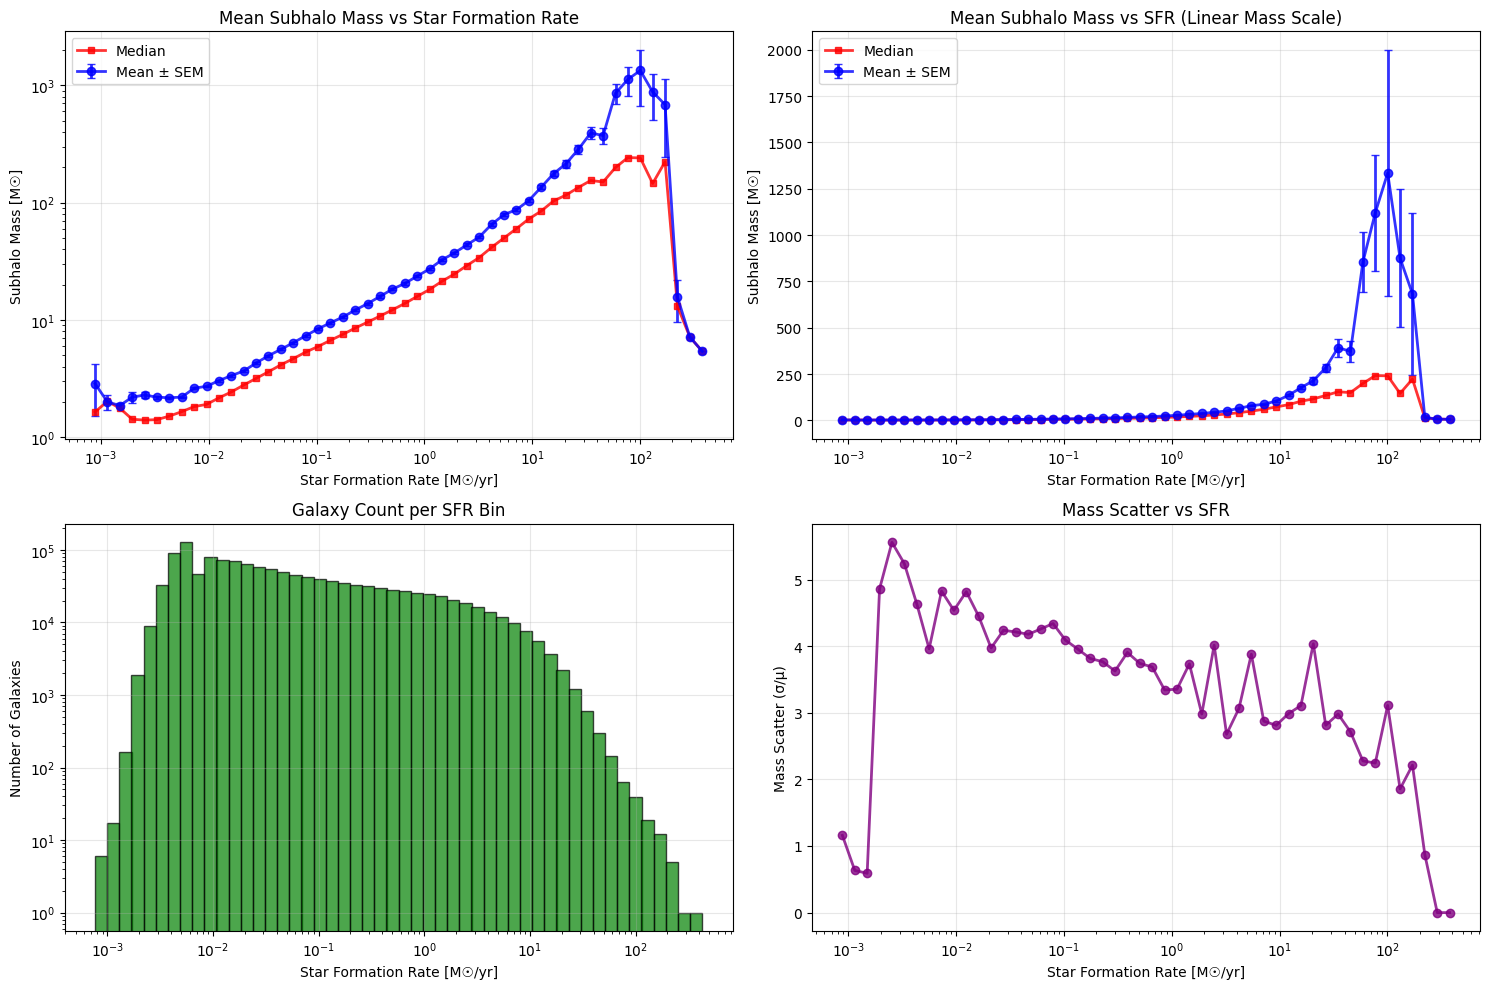


=== Mass-SFR Relationship Statistics ===
Total star-forming galaxies: 1293573
SFR range: 8.80e-04 to 3.78e+02 M☉/yr
Mass range: 1.87e+00 to 1.33e+03 M☉
Log-log correlation coefficient: 0.832 (p = 7.32e-14)
Power law fit: M ∝ SFR^0.43 (R² = 0.692)


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class MassSFRAnalyzer:
    def __init__(self, pickle_file_path):
        """
        Initialize the mass-SFR analyzer
        
        Parameters:
        pickle_file_path (str): Path to the pickle file containing galaxy data
        """
        self.df = pd.read_pickle(pickle_file_path)
        print(f"Loaded {len(self.df)} galaxies")
        
        # Analyze the data
        self.analyze_data()
        
    def analyze_data(self):
        """
        Analyze the SFR and mass distributions
        """
        print("\n=== Data Analysis ===")
        
        # SFR statistics
        sfr_vals = self.df['SubhaloSFR'].values
        valid_sfr = sfr_vals[sfr_vals > 0]  # Only star-forming galaxies
        
        print(f"SFR statistics:")
        print(f"  Total objects: {len(sfr_vals)}")
        print(f"  Star-forming objects (SFR > 0): {len(valid_sfr)}")
        print(f"  Fraction star-forming: {len(valid_sfr)/len(sfr_vals):.3f}")
        if len(valid_sfr) > 0:
            print(f"  SFR range: {valid_sfr.min():.2e} to {valid_sfr.max():.2e}")
            print(f"  SFR median: {np.median(valid_sfr):.2e}")
            print(f"  SFR mean: {np.mean(valid_sfr):.2e}")
        
        # Mass statistics for star-forming galaxies
        star_forming_mask = sfr_vals > 0
        masses_sf = self.df[star_forming_mask]['SubhaloMass'].values
        valid_masses_sf = masses_sf[masses_sf > 0]
        
        print(f"\nMass statistics (star-forming galaxies only):")
        if len(valid_masses_sf) > 0:
            print(f"  Mass range: {valid_masses_sf.min():.2e} to {valid_masses_sf.max():.2e}")
            print(f"  Mass median: {np.median(valid_masses_sf):.2e}")
            print(f"  Mass mean: {np.mean(valid_masses_sf):.2e}")
        
    def create_sfr_bins(self, n_bins=20, sfr_min=None, sfr_max=None, log_bins=True):
        """
        Create SFR bins for analysis
        
        Parameters:
        n_bins (int): Number of SFR bins
        sfr_min, sfr_max (float): SFR range. If None, determined from data
        log_bins (bool): Use logarithmic binning
        """
        # Get star-forming galaxies only
        star_forming = self.df[self.df['SubhaloSFR'] > 0].copy()
        
        if len(star_forming) == 0:
            print("No star-forming galaxies found!")
            return None, None, None
            
        sfr_vals = star_forming['SubhaloSFR'].values
        
        # Set SFR range
        if sfr_min is None:
            sfr_min = sfr_vals.min()
        if sfr_max is None:
            sfr_max = sfr_vals.max()
            
        # Create bins
        if log_bins:
            # Logarithmic bins
            sfr_edges = np.logspace(np.log10(sfr_min), np.log10(sfr_max), n_bins + 1)
            sfr_centers = np.sqrt(sfr_edges[:-1] * sfr_edges[1:])  # Geometric mean
        else:
            # Linear bins
            sfr_edges = np.linspace(sfr_min, sfr_max, n_bins + 1)
            sfr_centers = 0.5 * (sfr_edges[:-1] + sfr_edges[1:])  # Arithmetic mean
            
        return star_forming, sfr_edges, sfr_centers
    
    def compute_mean_mass_vs_sfr(self, n_bins=20, sfr_min=None, sfr_max=None, 
                                log_bins=True, mass_min=0):
        """
        Compute mean subhalo mass as a function of SFR
        
        Parameters:
        n_bins (int): Number of SFR bins
        sfr_min, sfr_max (float): SFR range
        log_bins (bool): Use logarithmic binning
        mass_min (float): Minimum mass threshold
        """
        # Get star-forming galaxies
        star_forming, sfr_edges, sfr_centers = self.create_sfr_bins(
            n_bins, sfr_min, sfr_max, log_bins)
        
        if star_forming is None:
            return None
            
        # Apply mass cut
        if mass_min > 0:
            star_forming = star_forming[star_forming['SubhaloMass'] > mass_min]
            print(f"Applied mass cut > {mass_min:.2e}: {len(star_forming)} galaxies remaining")
        
        # Initialize arrays for results
        mean_masses = np.zeros(len(sfr_centers))
        std_masses = np.zeros(len(sfr_centers))
        median_masses = np.zeros(len(sfr_centers))
        counts = np.zeros(len(sfr_centers))
        
        # Calculate statistics for each SFR bin
        for i in range(len(sfr_centers)):
            mask = ((star_forming['SubhaloSFR'] >= sfr_edges[i]) & 
                   (star_forming['SubhaloSFR'] < sfr_edges[i+1]))
            
            masses_in_bin = star_forming[mask]['SubhaloMass'].values
            
            if len(masses_in_bin) > 0:
                mean_masses[i] = np.mean(masses_in_bin)
                std_masses[i] = np.std(masses_in_bin)
                median_masses[i] = np.median(masses_in_bin)
                counts[i] = len(masses_in_bin)
            else:
                mean_masses[i] = np.nan
                std_masses[i] = np.nan
                median_masses[i] = np.nan
                counts[i] = 0
        
        # Remove empty bins
        valid_bins = counts > 0
        
        results = {
            'sfr_centers': sfr_centers[valid_bins],
            'sfr_edges': sfr_edges,
            'mean_masses': mean_masses[valid_bins],
            'std_masses': std_masses[valid_bins],
            'median_masses': median_masses[valid_bins],
            'counts': counts[valid_bins],
            'total_galaxies': len(star_forming)
        }
        
        print(f"\nBinning results:")
        print(f"  Total star-forming galaxies: {len(star_forming)}")
        print(f"  SFR bins with data: {np.sum(valid_bins)}/{len(sfr_centers)}")
        print(f"  SFR range: {sfr_centers[valid_bins].min():.2e} to {sfr_centers[valid_bins].max():.2e}")
        
        return results
    
    def plot_mass_vs_sfr(self, results=None, n_bins=20, sfr_min=None, sfr_max=None, 
                        log_bins=True, mass_min=0, figsize=(15, 10)):
        """
        Plot mean subhalo mass as a function of SFR
        
        Parameters:
        results (dict): Pre-computed results. If None, will compute
        Other parameters: Same as compute_mean_mass_vs_sfr
        figsize (tuple): Figure size
        """
        # Compute results if not provided
        if results is None:
            results = self.compute_mean_mass_vs_sfr(n_bins, sfr_min, sfr_max, 
                                                  log_bins, mass_min)
        
        if results is None:
            print("No data to plot!")
            return
        
        # Create figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        sfr_centers = results['sfr_centers']
        mean_masses = results['mean_masses']
        std_masses = results['std_masses']
        median_masses = results['median_masses']
        counts = results['counts']
        
        # Plot 1: Mean mass vs SFR with error bars
        ax1 = axes[0, 0]
        ax1.errorbar(sfr_centers, mean_masses, yerr=std_masses/np.sqrt(counts),
                    fmt='o-', capsize=3, capthick=1, linewidth=2, markersize=6,
                    label='Mean ± SEM', color='blue', alpha=0.8)
        ax1.plot(sfr_centers, median_masses, 's-', linewidth=2, markersize=5,
                label='Median', color='red', alpha=0.8)
        
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.set_xlabel('Star Formation Rate [M☉/yr]')
        ax1.set_ylabel('Subhalo Mass [M☉]')
        ax1.set_title('Mean Subhalo Mass vs Star Formation Rate')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Plot 2: Same but linear scale for mass
        ax2 = axes[0, 1]
        ax2.errorbar(sfr_centers, mean_masses, yerr=std_masses/np.sqrt(counts),
                    fmt='o-', capsize=3, capthick=1, linewidth=2, markersize=6,
                    label='Mean ± SEM', color='blue', alpha=0.8)
        ax2.plot(sfr_centers, median_masses, 's-', linewidth=2, markersize=5,
                label='Median', color='red', alpha=0.8)
        
        ax2.set_xscale('log')
        ax2.set_xlabel('Star Formation Rate [M☉/yr]')
        ax2.set_ylabel('Subhalo Mass [M☉]')
        ax2.set_title('Mean Subhalo Mass vs SFR (Linear Mass Scale)')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Plot 3: Number of galaxies per bin
        ax3 = axes[1, 0]
        ax3.bar(sfr_centers, counts, width=np.diff(results['sfr_edges']), 
               alpha=0.7, color='green', edgecolor='black')
        ax3.set_xscale('log')
        ax3.set_yscale('log')
        ax3.set_xlabel('Star Formation Rate [M☉/yr]')
        ax3.set_ylabel('Number of Galaxies')
        ax3.set_title('Galaxy Count per SFR Bin')
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Mass scatter (standard deviation) vs SFR
        ax4 = axes[1, 1]
        scatter_frac = std_masses / mean_masses  # Fractional scatter
        ax4.plot(sfr_centers, scatter_frac, 'o-', linewidth=2, markersize=6,
                color='purple', alpha=0.8)
        ax4.set_xscale('log')
        ax4.set_xlabel('Star Formation Rate [M☉/yr]')
        ax4.set_ylabel('Mass Scatter (σ/μ)')
        ax4.set_title('Mass Scatter vs SFR')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print some statistics
        print(f"\n=== Mass-SFR Relationship Statistics ===")
        print(f"Total star-forming galaxies: {results['total_galaxies']}")
        print(f"SFR range: {sfr_centers.min():.2e} to {sfr_centers.max():.2e} M☉/yr")
        print(f"Mass range: {mean_masses.min():.2e} to {mean_masses.max():.2e} M☉")
        
        # Compute correlation
        valid_data = ~np.isnan(mean_masses) & ~np.isnan(sfr_centers)
        if np.sum(valid_data) > 3:
            correlation, p_value = stats.pearsonr(np.log10(sfr_centers[valid_data]), 
                                                 np.log10(mean_masses[valid_data]))
            print(f"Log-log correlation coefficient: {correlation:.3f} (p = {p_value:.2e})")
            
            # Fit power law: M ∝ SFR^α
            log_sfr = np.log10(sfr_centers[valid_data])
            log_mass = np.log10(mean_masses[valid_data])
            slope, intercept, r_value, p_value, std_err = stats.linregress(log_sfr, log_mass)
            print(f"Power law fit: M ∝ SFR^{slope:.2f} (R² = {r_value**2:.3f})")
        
        return results
    
    def run_analysis(self, n_bins=25, log_bins=True, mass_min=0, 
                    sfr_min=None, sfr_max=None):
        """
        Run the complete mass-SFR analysis
        
        Parameters:
        n_bins (int): Number of SFR bins
        log_bins (bool): Use logarithmic binning
        mass_min (float): Minimum mass threshold
        sfr_min, sfr_max (float): SFR range
        """
        print("=== Mean Subhalo Mass vs SFR Analysis ===")
        
        # Compute and plot results
        results = self.plot_mass_vs_sfr(
            n_bins=n_bins, 
            log_bins=log_bins, 
            mass_min=mass_min,
            sfr_min=sfr_min,
            sfr_max=sfr_max
        )
        
        return results

# Example usage
if __name__ == "__main__":
    # Initialize the analyzer
    file_path = '/gpfs/nchugh/groupcat_data/subhalos_snap_50.pkl'
    
    # Create analyzer instance
    analyzer = MassSFRAnalyzer(file_path)
    
    # Run basic analysis
    print("\n" + "="*60)
    print("Running analysis with all star-forming galaxies:")
    results = analyzer.run_analysis(
        n_bins=50,          # Number of SFR bins
        log_bins=True,      # Logarithmic SFR binning
        mass_min=0          # No mass cut
    )
    
    # You can also run with different parameters:
    # 
    # # Analysis with mass cut
    # print("\n" + "="*60)
    # print("Running analysis with mass cut:")
    # results_mass_cut = analyzer.run_analysis(
    #     n_bins=20,
    #     mass_min=1e8,      # Only galaxies with M > 10^8
    #     sfr_min=1e-3,      # Minimum SFR
    #     sfr_max=100        # Maximum SFR
    # )
    #
    # # Analysis with linear binning
    # print("\n" + "="*60)
    # print("Running analysis with linear SFR binning:")
    # results_linear = analyzer.run_analysis(
    #     n_bins=15,
    #     log_bins=False,    # Linear binning
    #     mass_min=1e7
    # )

In [1]:
from pypower import CatalogMesh, MeshFFTPower, CatalogFFTPower, PowerSpectrumStatistics, utils, setup_logging

In [1]:
import pickle
import pandas as pd

# Try loading with pickle directly first
file_path = '/gpfs/nchugh/groupcat_data/subhalos_snap_99.pkl'

try:
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
    print("Loaded successfully with pickle")
    print(df.dtypes)
except Exception as e:
    print(f"Pickle loading failed: {e}")
    
    # Alternative: try with pandas but handle the error
    try:
        df = pd.read_pickle(file_path)
        print("Loaded successfully with pandas")
        print(df.dtypes)
    except Exception as e2:
        print(f"Pandas loading also failed: {e2}")

Loaded successfully with pickle
SubhaloFlag                  bool
SubhaloMass               float32
SubhaloSFR                float32
SubhaloParent               int32
SubhaloPos_0              float32
SubhaloPos_1              float32
SubhaloPos_2              float32
SubhaloStarMetallicity    float32
SubhaloGasMetallicity     float32
SubhaloMassStars          float32
SubhaloMassBH             float32
SubhaloVel_0              float32
SubhaloVel_1              float32
SubhaloVel_2              float32
SubhaloVelDisp            float32
SubhaloGrNr                 int32
SubhaloVmax               float32
SubhaloSpin_0             float32
SubhaloSpin_1             float32
SubhaloSpin_2             float32
Redshift                  float64
dtype: object


In [6]:
# Convert the pickle files to a CSV folder. We will later use this to pickle in a python 3.8 module
import os
import pandas as pd

def convert_pickle_to_csv(pickle_file_path, output_dir):
    """
    Convert a pickle file to CSV format.
    
    Parameters:
    pickle_file_path (str): Path to the input pickle file.
    output_dir (str): Directory where the CSV file will be saved.
    """
    try:
        # Load the DataFrame from the pickle file
        df = pd.read_pickle(pickle_file_path)
        
        # Ensure output directory exists
        os.makedirs(output_dir, exist_ok=True)
        
        # Extract the base filename without extension and add .csv
        base_filename = os.path.splitext(os.path.basename(pickle_file_path))[0]
        csv_filename = f"{base_filename}.csv"
        
        # Define output CSV file path
        csv_file_path = os.path.join(output_dir, csv_filename)
        
        # Save DataFrame to CSV
        df.to_csv(csv_file_path, index=False)
        
        print(f"Converted {pickle_file_path} to {csv_file_path}")
    except Exception as e:
        print(f"Error converting pickle to CSV: {e}")
        
# Example usage
for snapshot in range(50, 100):
    pickle_file = f'/gpfs/nchugh/groupcat_data/subhalos_snap_{snapshot:02d}.pkl'
    output_directory = '/gpfs/nchugh/groupcat_data/csv_output'
    
    if os.path.exists(pickle_file):
        print(f"Processing snapshot {snapshot}...")
        convert_pickle_to_csv(pickle_file, output_directory)
        print(f"Processed snapshot {snapshot}")
    else:
        print(f"File not found: {pickle_file}")

Processing snapshot 50...
Converted /gpfs/nchugh/groupcat_data/subhalos_snap_50.pkl to /gpfs/nchugh/groupcat_data/csv_output/subhalos_snap_50.csv
Processed snapshot 50
Processing snapshot 51...
Converted /gpfs/nchugh/groupcat_data/subhalos_snap_51.pkl to /gpfs/nchugh/groupcat_data/csv_output/subhalos_snap_51.csv
Processed snapshot 51
Processing snapshot 52...
Converted /gpfs/nchugh/groupcat_data/subhalos_snap_52.pkl to /gpfs/nchugh/groupcat_data/csv_output/subhalos_snap_52.csv
Processed snapshot 52
Processing snapshot 53...
Converted /gpfs/nchugh/groupcat_data/subhalos_snap_53.pkl to /gpfs/nchugh/groupcat_data/csv_output/subhalos_snap_53.csv
Processed snapshot 53
Processing snapshot 54...
Converted /gpfs/nchugh/groupcat_data/subhalos_snap_54.pkl to /gpfs/nchugh/groupcat_data/csv_output/subhalos_snap_54.csv
Processed snapshot 54
Processing snapshot 55...
Converted /gpfs/nchugh/groupcat_data/subhalos_snap_55.pkl to /gpfs/nchugh/groupcat_data/csv_output/subhalos_snap_55.csv
Processed snap

In [5]:
# Convert CSV files back to pickle files
import os
import pandas as pd
from pathlib import Path

def convert_csv_to_pickle(csv_file_path, output_dir):
    """
    Convert a CSV file to pickle format.
    
    Parameters:
    csv_file_path (str): Path to the input CSV file.
    output_dir (str): Directory where the pickle file will be saved.
    """
    try:
        # Load the DataFrame from the CSV file
        df = pd.read_csv(csv_file_path)
        
        # Ensure output directory exists
        os.makedirs(output_dir, exist_ok=True)
        
        # Extract the base filename without extension and add .pkl
        base_filename = os.path.splitext(os.path.basename(csv_file_path))[0]
        pkl_filename = f"{base_filename}.pkl"
        
        # Define output pickle file path
        pkl_file_path = os.path.join(output_dir, pkl_filename)
        
        # Save DataFrame to pickle
        df.to_pickle(pkl_file_path)
        
        print(f"Converted {csv_file_path} to {pkl_file_path}")
        
    except Exception as e:
        print(f"Error converting CSV to pickle: {e}")

def convert_all_csv_to_pickle(input_dir, output_dir):
    """
    Convert all CSV files in a directory to pickle files.
    
    Parameters:
    input_dir (str): Directory containing CSV files
    output_dir (str): Directory where pickle files will be saved
    """
    input_path = Path(input_dir)
    
    # Find all CSV files
    csv_files = list(input_path.glob("*.csv"))
    
    if not csv_files:
        print(f"No CSV files found in {input_dir}")
        return
    
    print(f"Found {len(csv_files)} CSV files to convert")
    print(f"Input directory: {input_dir}")
    print(f"Output directory: {output_dir}")
    print("-" * 50)
    
    success_count = 0
    error_count = 0
    
    for csv_file in sorted(csv_files):
        try:
            convert_csv_to_pickle(str(csv_file), output_dir)
            success_count += 1
        except Exception as e:
            print(f"Failed to convert {csv_file.name}: {e}")
            error_count += 1
        print()  # Add spacing between files
    
    print("-" * 50)
    print(f"Conversion complete!")
    print(f"Successfully converted: {success_count} files")
    print(f"Errors: {error_count} files")

def convert_specific_snapshots(input_dir, output_dir, snapshot_range=None):
    """
    Convert specific snapshot CSV files to pickle files.
    
    Parameters:
    input_dir (str): Directory containing CSV files
    output_dir (str): Directory where pickle files will be saved
    snapshot_range (tuple): (start, end) snapshot numbers, or None for all
    """
    input_path = Path(input_dir)
    
    if snapshot_range:
        start_snap, end_snap = snapshot_range
        print(f"Converting snapshots {start_snap} to {end_snap}")
        
        for snapshot in range(start_snap, end_snap + 1):
            csv_file = input_path / f"subhalos_snap_{snapshot:02d}.csv"
            
            if csv_file.exists():
                print(f"Processing snapshot {snapshot}...")
                convert_csv_to_pickle(str(csv_file), output_dir)
            else:
                print(f"File not found: {csv_file}")
    else:
        # Convert all CSV files
        convert_all_csv_to_pickle(input_dir, output_dir)

# Example usage options:

if __name__ == "__main__":
    # Option 1: Convert all CSV files
    input_directory = '/gpfs/nchugh/groupcat_data/csv_output'
    output_directory = '/gpfs/nchugh/groupcat_data/pickle_output'
    
    print("Converting all CSV files to pickle format...")
    convert_all_csv_to_pickle(input_directory, output_directory)
    
    # Option 2: Convert specific range of snapshots
    # print("Converting snapshots 50-99 to pickle format...")
    # convert_specific_snapshots(input_directory, output_directory, (50, 99))
    
    # Option 3: Convert individual file
    # csv_file = '/gpfs/nchugh/groupcat_data/csv_output/subhalos_snap_99.csv'
    # convert_csv_to_pickle(csv_file, output_directory)

Converting all CSV files to pickle format...
Found 50 CSV files to convert
Input directory: /gpfs/nchugh/groupcat_data/csv_output
Output directory: /gpfs/nchugh/groupcat_data/pickle_output
--------------------------------------------------
Converted /gpfs/nchugh/groupcat_data/csv_output/subhalos_snap_50.csv to /gpfs/nchugh/groupcat_data/pickle_output/subhalos_snap_50.pkl

Converted /gpfs/nchugh/groupcat_data/csv_output/subhalos_snap_51.csv to /gpfs/nchugh/groupcat_data/pickle_output/subhalos_snap_51.pkl

Converted /gpfs/nchugh/groupcat_data/csv_output/subhalos_snap_52.csv to /gpfs/nchugh/groupcat_data/pickle_output/subhalos_snap_52.pkl

Converted /gpfs/nchugh/groupcat_data/csv_output/subhalos_snap_53.csv to /gpfs/nchugh/groupcat_data/pickle_output/subhalos_snap_53.pkl

Converted /gpfs/nchugh/groupcat_data/csv_output/subhalos_snap_54.csv to /gpfs/nchugh/groupcat_data/pickle_output/subhalos_snap_54.pkl

Converted /gpfs/nchugh/groupcat_data/csv_output/subhalos_snap_55.csv to /gpfs/nchugh/

In [5]:
# Open some pickle file from the pickle_output directory
import os
import pandas as pd

df = pd.read_pickle('/gpfs/nchugh/groupcat_data/pickle_output/subhalos_snap_99.pkl')
print(df.dtypes)

SubhaloFlag                  bool
SubhaloMass               float64
SubhaloSFR                float64
SubhaloParent               int64
SubhaloPos_0              float64
SubhaloPos_1              float64
SubhaloPos_2              float64
SubhaloStarMetallicity    float64
SubhaloGasMetallicity     float64
SubhaloMassStars          float64
SubhaloMassBH             float64
SubhaloVel_0              float64
SubhaloVel_1              float64
SubhaloVel_2              float64
SubhaloVelDisp            float64
SubhaloGrNr                 int64
SubhaloVmax               float64
SubhaloSpin_0             float64
SubhaloSpin_1             float64
SubhaloSpin_2             float64
Redshift                  float64
dtype: object


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class MassSFRAnalyzer:
    def __init__(self, pickle_file_path):
        """
        Initialize the mass-SFR analyzer
        
        Parameters:
        pickle_file_path (str): Path to the pickle file containing galaxy data
        """
        self.df = pd.read_pickle(pickle_file_path)
        print(f"Loaded {len(self.df)} galaxies")
        
        # Check required columns
        required_cols = ['SubhaloSFR', 'SubhaloMass']
        missing_cols = [col for col in required_cols if col not in self.df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")
        
        # Analyze the data
        self.analyze_data()
        
    def analyze_data(self):
        """
        Analyze the SFR and mass distributions
        """
        print("\n=== Data Analysis ===")
        
        # SFR statistics
        sfr_vals = self.df['SubhaloSFR'].values
        valid_sfr = sfr_vals[sfr_vals > 0]  # Only star-forming galaxies
        
        print(f"SFR statistics:")
        print(f"  Total objects: {len(sfr_vals)}")
        print(f"  Star-forming objects (SFR > 0): {len(valid_sfr)}")
        print(f"  Fraction star-forming: {len(valid_sfr)/len(sfr_vals):.3f}")
        if len(valid_sfr) > 0:
            print(f"  SFR range: {valid_sfr.min():.2e} to {valid_sfr.max():.2e}")
            print(f"  SFR median: {np.median(valid_sfr):.2e}")
            print(f"  SFR mean: {np.mean(valid_sfr):.2e}")
        
        # Mass statistics for star-forming galaxies
        star_forming_mask = sfr_vals > 0
        masses_sf = self.df[star_forming_mask]['SubhaloMass'].values
        valid_masses_sf = masses_sf[masses_sf > 0]
        
        print(f"\nMass statistics (star-forming galaxies only):")
        if len(valid_masses_sf) > 0:
            print(f"  Mass range: {valid_masses_sf.min():.2e} to {valid_masses_sf.max():.2e}")
            print(f"  Mass median: {np.median(valid_masses_sf):.2e}")
            print(f"  Mass mean: {np.mean(valid_masses_sf):.2e}")
        
    def create_sfr_bins(self, n_bins=20, sfr_min=None, sfr_max=None, log_bins=True):
        """
        Create SFR bins for analysis
        
        Parameters:
        n_bins (int): Number of SFR bins
        sfr_min, sfr_max (float): SFR range. If None, determined from data
        log_bins (bool): Use logarithmic binning
        """
        # Get star-forming galaxies only
        star_forming = self.df[(self.df['SubhaloSFR'] > 0) & (self.df['SubhaloMass'] > 0)].copy()
        
        if len(star_forming) == 0:
            print("No star-forming galaxies found!")
            return None, None, None
            
        sfr_vals = star_forming['SubhaloSFR'].values
        
        # Set SFR range
        if sfr_min is None:
            sfr_min = sfr_vals.min()
        if sfr_max is None:
            sfr_max = sfr_vals.max()
            
        # Create bins
        if log_bins:
            # Logarithmic bins
            sfr_edges = np.logspace(np.log10(sfr_min), np.log10(sfr_max), n_bins + 1)
            sfr_centers = np.sqrt(sfr_edges[:-1] * sfr_edges[1:])  # Geometric mean
        else:
            # Linear bins
            sfr_edges = np.linspace(sfr_min, sfr_max, n_bins + 1)
            sfr_centers = 0.5 * (sfr_edges[:-1] + sfr_edges[1:])  # Arithmetic mean
            
        return star_forming, sfr_edges, sfr_centers
    
    def compute_mean_mass_vs_sfr(self, n_bins=20, sfr_min=None, sfr_max=None, 
                                log_bins=True, mass_min=0, min_galaxies_per_bin=5):
        """
        Compute mean subhalo mass as a function of SFR
        
        Parameters:
        n_bins (int): Number of SFR bins
        sfr_min, sfr_max (float): SFR range
        log_bins (bool): Use logarithmic binning
        mass_min (float): Minimum mass threshold
        min_galaxies_per_bin (int): Minimum galaxies required per bin
        """
        # Get star-forming galaxies
        star_forming, sfr_edges, sfr_centers = self.create_sfr_bins(
            n_bins, sfr_min, sfr_max, log_bins)
        
        if star_forming is None:
            return None
            
        # Apply mass cut
        if mass_min > 0:
            star_forming = star_forming[star_forming['SubhaloMass'] > mass_min]
            print(f"Applied mass cut > {mass_min:.2e}: {len(star_forming)} galaxies remaining")
        
        # Initialize arrays for results
        mean_masses = np.full(len(sfr_centers), np.nan)
        std_masses = np.full(len(sfr_centers), np.nan)
        median_masses = np.full(len(sfr_centers), np.nan)
        counts = np.zeros(len(sfr_centers))
        
        # Calculate statistics for each SFR bin
        for i in range(len(sfr_centers)):
            mask = ((star_forming['SubhaloSFR'] >= sfr_edges[i]) & 
                   (star_forming['SubhaloSFR'] < sfr_edges[i+1]))
            
            masses_in_bin = star_forming[mask]['SubhaloMass'].values
            
            if len(masses_in_bin) >= min_galaxies_per_bin:
                mean_masses[i] = np.mean(masses_in_bin)
                std_masses[i] = np.std(masses_in_bin)
                median_masses[i] = np.median(masses_in_bin)
                counts[i] = len(masses_in_bin)
        
        # Remove empty bins
        valid_bins = ~np.isnan(mean_masses)
        
        if not np.any(valid_bins):
            print("No bins with sufficient galaxies found!")
            return None
        
        results = {
            'sfr_centers': sfr_centers[valid_bins],
            'sfr_edges': sfr_edges,
            'mean_masses': mean_masses[valid_bins],
            'std_masses': std_masses[valid_bins],
            'median_masses': median_masses[valid_bins],
            'counts': counts[valid_bins],
            'total_galaxies': len(star_forming)
        }
        
        print(f"\nBinning results:")
        print(f"  Total star-forming galaxies: {len(star_forming)}")
        print(f"  SFR bins with data: {np.sum(valid_bins)}/{len(sfr_centers)}")
        print(f"  SFR range: {results['sfr_centers'].min():.2e} to {results['sfr_centers'].max():.2e}")
        
        return results
    
    def plot_mass_vs_sfr(self, results=None, n_bins=20, sfr_min=None, sfr_max=None, 
                        log_bins=True, mass_min=0, figsize=(15, 10), save_path=None):
        """
        Plot mean subhalo mass as a function of SFR
        
        Parameters:
        results (dict): Pre-computed results. If None, will compute
        save_path (str): Path to save figure. If None, only displays
        Other parameters: Same as compute_mean_mass_vs_sfr
        figsize (tuple): Figure size
        """
        # Compute results if not provided
        if results is None:
            results = self.compute_mean_mass_vs_sfr(n_bins, sfr_min, sfr_max, 
                                                  log_bins, mass_min)
        
        if results is None:
            print("No data to plot!")
            return None
        
        # Create figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        sfr_centers = results['sfr_centers']
        mean_masses = results['mean_masses']
        std_masses = results['std_masses']
        median_masses = results['median_masses']
        counts = results['counts']
        
        # Plot 1: Mean mass vs SFR with error bars
        ax1 = axes[0, 0]
        ax1.errorbar(sfr_centers, mean_masses, yerr=std_masses/np.sqrt(counts),
                    fmt='o-', capsize=3, capthick=1, linewidth=2, markersize=6,
                    label='Mean ± SEM', color='blue', alpha=0.8)
        ax1.plot(sfr_centers, median_masses, 's-', linewidth=2, markersize=5,
                label='Median', color='red', alpha=0.8)
        
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.set_xlabel('Star Formation Rate [M☉/yr]')
        ax1.set_ylabel('Subhalo Mass [M☉]')
        ax1.set_title('Mean Subhalo Mass vs Star Formation Rate')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Plot 2: Same but linear scale for mass
        ax2 = axes[0, 1]
        ax2.errorbar(sfr_centers, mean_masses, yerr=std_masses/np.sqrt(counts),
                    fmt='o-', capsize=3, capthick=1, linewidth=2, markersize=6,
                    label='Mean ± SEM', color='blue', alpha=0.8)
        ax2.plot(sfr_centers, median_masses, 's-', linewidth=2, markersize=5,
                label='Median', color='red', alpha=0.8)
        
        ax2.set_xscale('log')
        ax2.set_xlabel('Star Formation Rate [M☉/yr]')
        ax2.set_ylabel('Subhalo Mass [M☉]')
        ax2.set_title('Mean Subhalo Mass vs SFR (Linear Mass Scale)')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Plot 3: Number of galaxies per bin
        ax3 = axes[1, 0]
        # Use bar widths proportional to bin edges for log scale
        bin_widths = np.diff(results['sfr_edges'])
        valid_widths = []
        for i, center in enumerate(sfr_centers):
            # Find which bin this center belongs to
            bin_idx = np.searchsorted(results['sfr_edges'], center) - 1
            if bin_idx >= 0 and bin_idx < len(bin_widths):
                valid_widths.append(bin_widths[bin_idx])
            else:
                valid_widths.append(center * 0.1)  # fallback width
        
        ax3.bar(sfr_centers, counts, width=valid_widths, 
               alpha=0.7, color='green', edgecolor='black')
        ax3.set_xscale('log')
        ax3.set_yscale('log')
        ax3.set_xlabel('Star Formation Rate [M☉/yr]')
        ax3.set_ylabel('Number of Galaxies')
        ax3.set_title('Galaxy Count per SFR Bin')
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Mass scatter (standard deviation) vs SFR
        ax4 = axes[1, 1]
        scatter_frac = std_masses / mean_masses  # Fractional scatter
        ax4.plot(sfr_centers, scatter_frac, 'o-', linewidth=2, markersize=6,
                color='purple', alpha=0.8)
        ax4.set_xscale('log')
        ax4.set_xlabel('Star Formation Rate [M☉/yr]')
        ax4.set_ylabel('Mass Scatter (σ/μ)')
        ax4.set_title('Mass Scatter vs SFR')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Figure saved to: {save_path}")
        
        plt.show()
        
        # Print statistics and fit power law
        self._print_statistics(results)
        
        return results
    
    def _print_statistics(self, results):
        """Print statistics and fit power law"""
        sfr_centers = results['sfr_centers']
        mean_masses = results['mean_masses']
        
        print(f"\n=== Mass-SFR Relationship Statistics ===")
        print(f"Total star-forming galaxies: {results['total_galaxies']}")
        print(f"SFR range: {sfr_centers.min():.2e} to {sfr_centers.max():.2e} M☉/yr")
        print(f"Mass range: {mean_masses.min():.2e} to {mean_masses.max():.2e} M☉")
        
        # Compute correlation and power law fit
        if len(sfr_centers) > 3:
            log_sfr = np.log10(sfr_centers)
            log_mass = np.log10(mean_masses)
            
            # Correlation
            correlation, p_value = stats.pearsonr(log_sfr, log_mass)
            print(f"Log-log correlation coefficient: {correlation:.3f} (p = {p_value:.2e})")
            
            # Power law fit: M ∝ SFR^α
            slope, intercept, r_value, p_value, std_err = stats.linregress(log_sfr, log_mass)
            print(f"Power law fit: M ∝ SFR^{slope:.2f} ± {std_err:.2f}")
            print(f"R² = {r_value**2:.3f}, p = {p_value:.2e}")
            print(f"Normalization: log₁₀(M/M☉) = {intercept:.2f} + {slope:.2f} × log₁₀(SFR)")
    
    def run_analysis(self, n_bins=25, log_bins=True, mass_min=0, 
                    sfr_min=None, sfr_max=None, save_path=None):
        """
        Run the complete mass-SFR analysis
        
        Parameters:
        n_bins (int): Number of SFR bins
        log_bins (bool): Use logarithmic binning
        mass_min (float): Minimum mass threshold
        sfr_min, sfr_max (float): SFR range
        save_path (str): Path to save figure
        """
        print("=== Mean Subhalo Mass vs SFR Analysis ===")
        
        # Compute and plot results
        results = self.plot_mass_vs_sfr(
            n_bins=n_bins, 
            log_bins=log_bins, 
            mass_min=mass_min,
            sfr_min=sfr_min,
            sfr_max=sfr_max,
            save_path=save_path
        )
        
        return results


/gpfs/nchugh/anaconda3/envs/pyenv/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Loaded 17120875 galaxies

=== Data Analysis ===
SFR statistics:
  Total objects: 17120875
  Star-forming objects (SFR > 0): 1293573
  Fraction star-forming: 0.076
  SFR range: 7.71e-04 to 4.31e+02
  SFR median: 3.01e-02
  SFR mean: 6.46e-01

Mass statistics (star-forming galaxies only):
  Mass range: 1.25e-02 to 3.00e+04
  Mass median: 3.31e+00
  Mass mean: 1.33e+01

Running analysis with mass cutoff at log(mass) > 9:
=== Mean Subhalo Mass vs SFR Analysis ===
Applied mass cut > 1.00e-01: 1259562 galaxies remaining

Binning results:
  Total star-forming galaxies: 1259562
  SFR bins with data: 48/50
  SFR range: 8.80e-04 to 2.22e+02
Figure saved to: mass_sfr_analysis_mass_cut.png


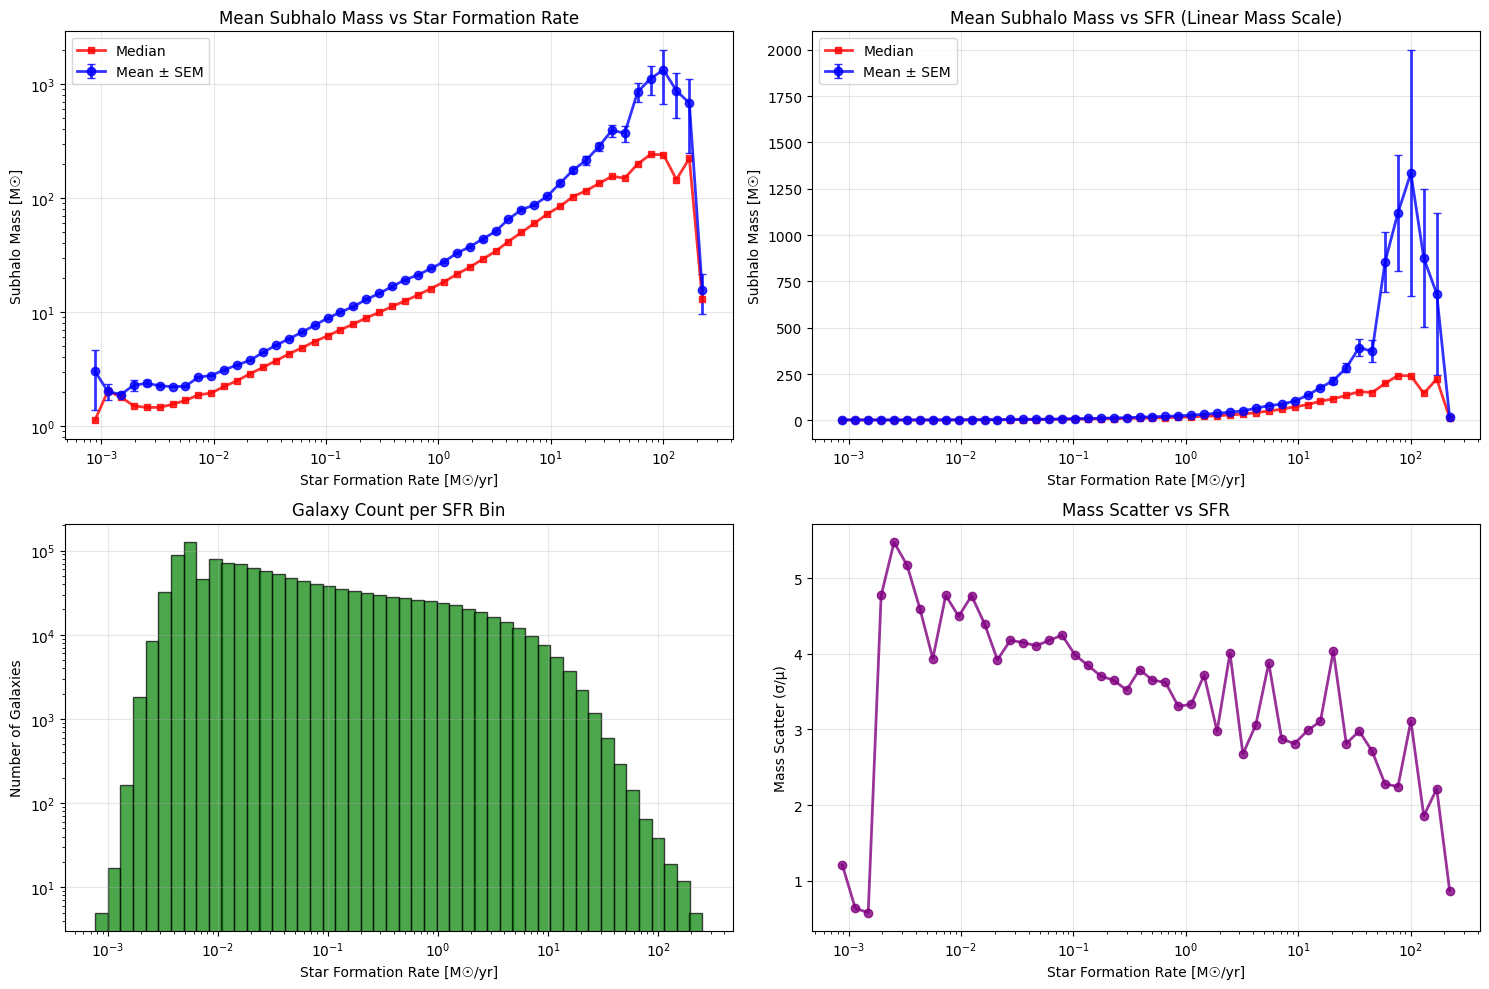


=== Mass-SFR Relationship Statistics ===
Total star-forming galaxies: 1259562
SFR range: 8.80e-04 to 2.22e+02 M☉/yr
Mass range: 1.89e+00 to 1.33e+03 M☉
Log-log correlation coefficient: 0.939 (p = 5.91e-23)
Power law fit: M ∝ SFR^0.51 ± 0.03
R² = 0.882, p = 5.91e-23
Normalization: log₁₀(M/M☉) = 1.55 + 0.51 × log₁₀(SFR)

Running analysis with all star-forming galaxies (no mass cut):
=== Mean Subhalo Mass vs SFR Analysis ===

Binning results:
  Total star-forming galaxies: 1293573
  SFR bins with data: 48/50
  SFR range: 8.80e-04 to 2.22e+02
Figure saved to: mass_sfr_analysis_no_cut.png


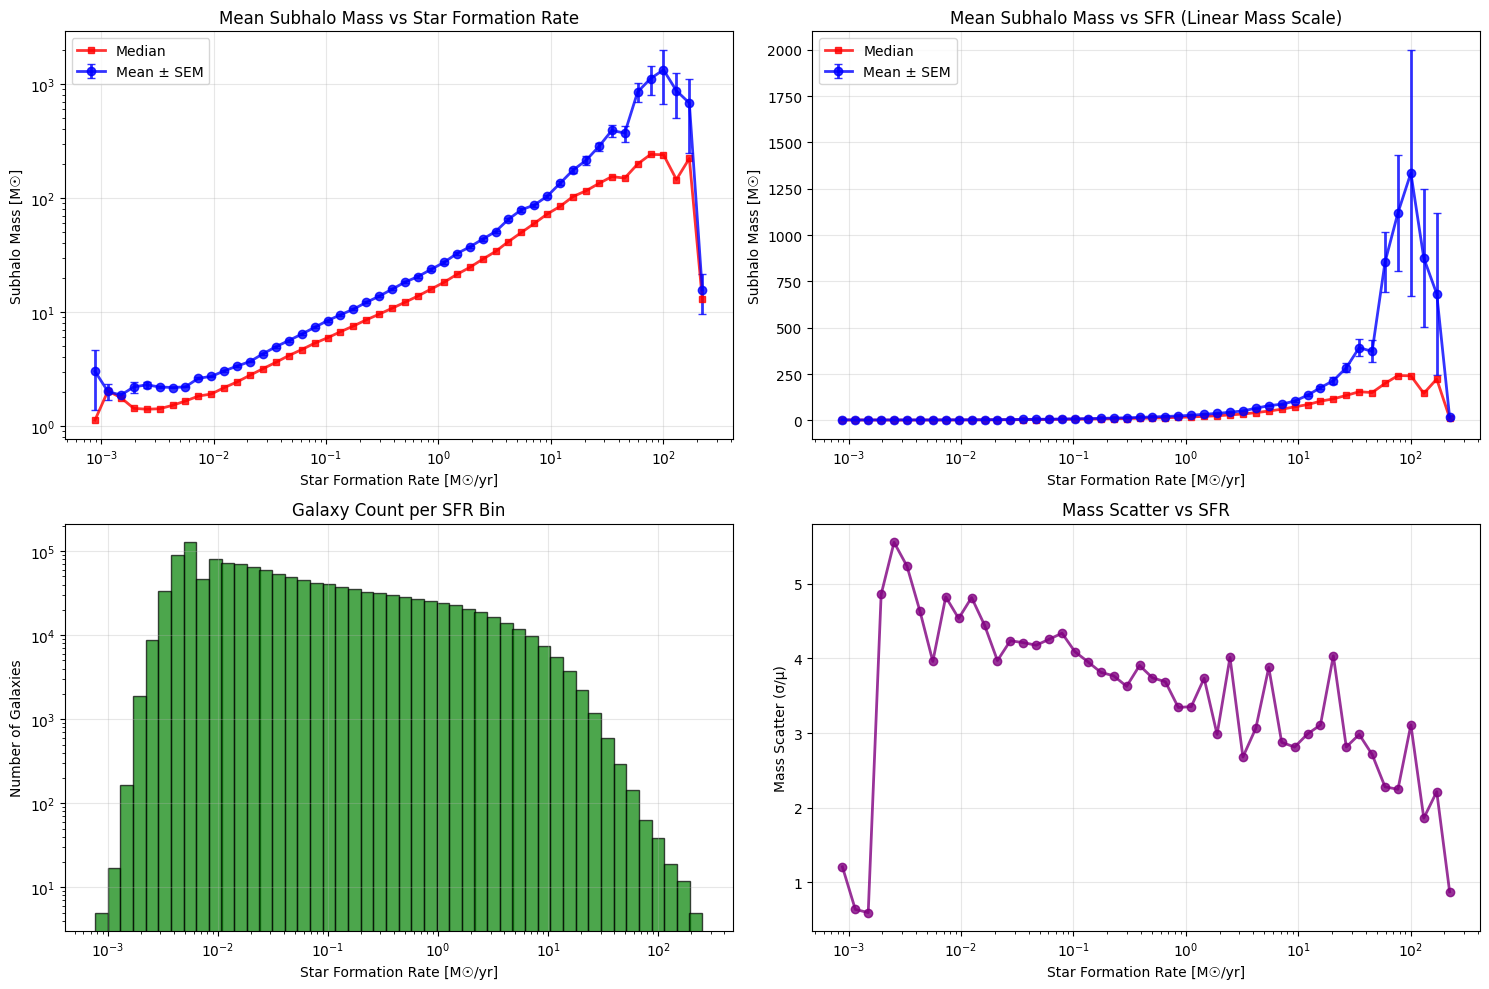


=== Mass-SFR Relationship Statistics ===
Total star-forming galaxies: 1293573
SFR range: 8.80e-04 to 2.22e+02 M☉/yr
Mass range: 1.87e+00 to 1.33e+03 M☉
Log-log correlation coefficient: 0.939 (p = 6.43e-23)
Power law fit: M ∝ SFR^0.51 ± 0.03
R² = 0.881, p = 6.43e-23
Normalization: log₁₀(M/M☉) = 1.54 + 0.51 × log₁₀(SFR)


In [3]:

# Example usage
if __name__ == "__main__":
    # Initialize the analyzer
    file_path = '/gpfs/nchugh/groupcat_data/pickle_output/subhalos_snap_50.pkl'
    
    try:
        # Create analyzer instance
        analyzer = MassSFRAnalyzer(file_path)
        
        # Run analysis with mass cutoff at log(mass) > 9 (mass > 10^9)
        print("\n" + "="*60)
        print("Running analysis with mass cutoff at log(mass) > 9:")
        results = analyzer.run_analysis(
            n_bins=50,          # Number of SFR bins
            log_bins=True,      # Logarithmic SFR binning
            mass_min=1e-1,       # Mass cutoff: only galaxies with M > 0.1 M☉
            save_path='mass_sfr_analysis_mass_cut.png'
        )
        
        # Compare with no mass cut
        print("\n" + "="*60)
        print("Running analysis with all star-forming galaxies (no mass cut):")
        results_no_cut = analyzer.run_analysis(
            n_bins=50,          # Number of SFR bins
            log_bins=True,      # Logarithmic SFR binning
            mass_min=0,         # No mass cut
            save_path='mass_sfr_analysis_no_cut.png'
        )
        
    except FileNotFoundError:
        print("Error: Pickle file not found. Please check the file path.")
    except Exception as e:
        print(f"Error: {e}")


Running analysis with mass cutoff at 1 M☉:
=== Mean Subhalo Mass vs SFR Analysis ===
Applied mass cut > 1.00e+00: 1037009 galaxies remaining

Binning results:
  Total star-forming galaxies: 1037009
  SFR bins with data: 47/50
  SFR range: 1.15e-03 to 2.22e+02
Figure saved to: mass_sfr_analysis_mass_cut_1M.png


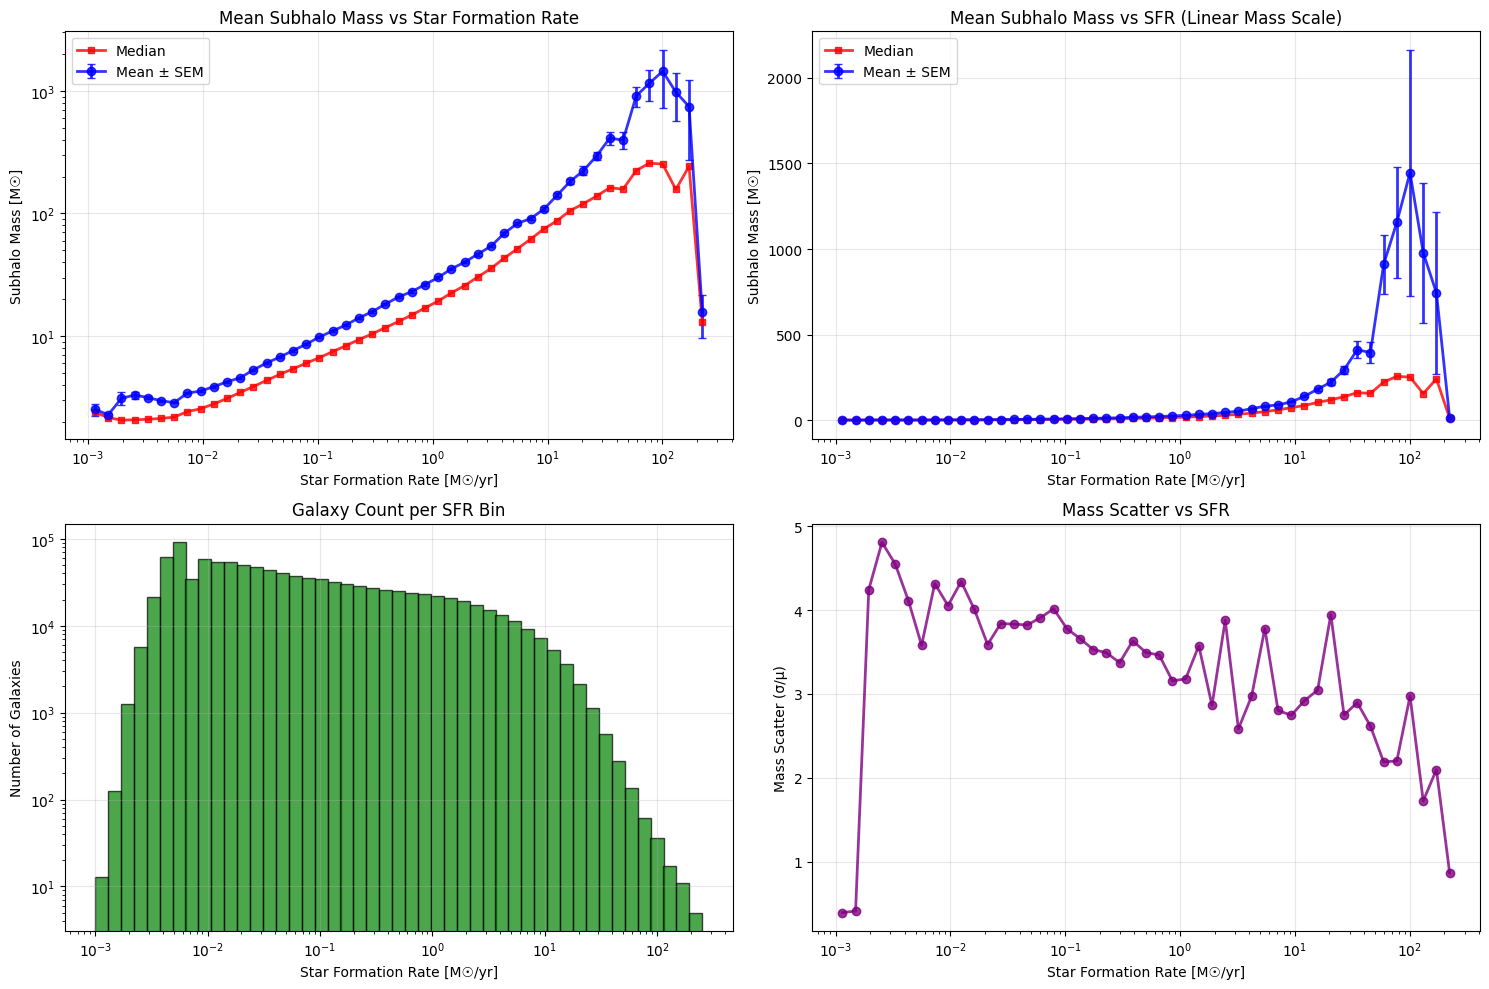


=== Mass-SFR Relationship Statistics ===
Total star-forming galaxies: 1037009
SFR range: 1.15e-03 to 2.22e+02 M☉/yr
Mass range: 2.28e+00 to 1.45e+03 M☉
Log-log correlation coefficient: 0.934 (p = 9.21e-22)
Power law fit: M ∝ SFR^0.50 ± 0.03
R² = 0.873, p = 9.21e-22
Normalization: log₁₀(M/M☉) = 1.59 + 0.50 × log₁₀(SFR)


In [4]:
# Applying mass cut at 1 solar mass (M☉)
print("\n" + "="*60)
print("Running analysis with mass cutoff at 1 M☉:")
results_mass_cut = analyzer.run_analysis(
    n_bins=50,          # Number of SFR bins
    log_bins=True,      # Logarithmic SFR binning
    mass_min=1.0,       # Mass cutoff: only galaxies with M > 1 M☉
    save_path='mass_sfr_analysis_mass_cut_1M.png'
)



Running analysis with mass cutoff at 10 M☉:
=== Mean Subhalo Mass vs SFR Analysis ===
Applied mass cut > 1.00e+01: 257681 galaxies remaining

Binning results:
  Total star-forming galaxies: 257681
  SFR bins with data: 44/50
  SFR range: 1.95e-03 to 1.71e+02
Figure saved to: mass_sfr_analysis_mass_cut_10M.png


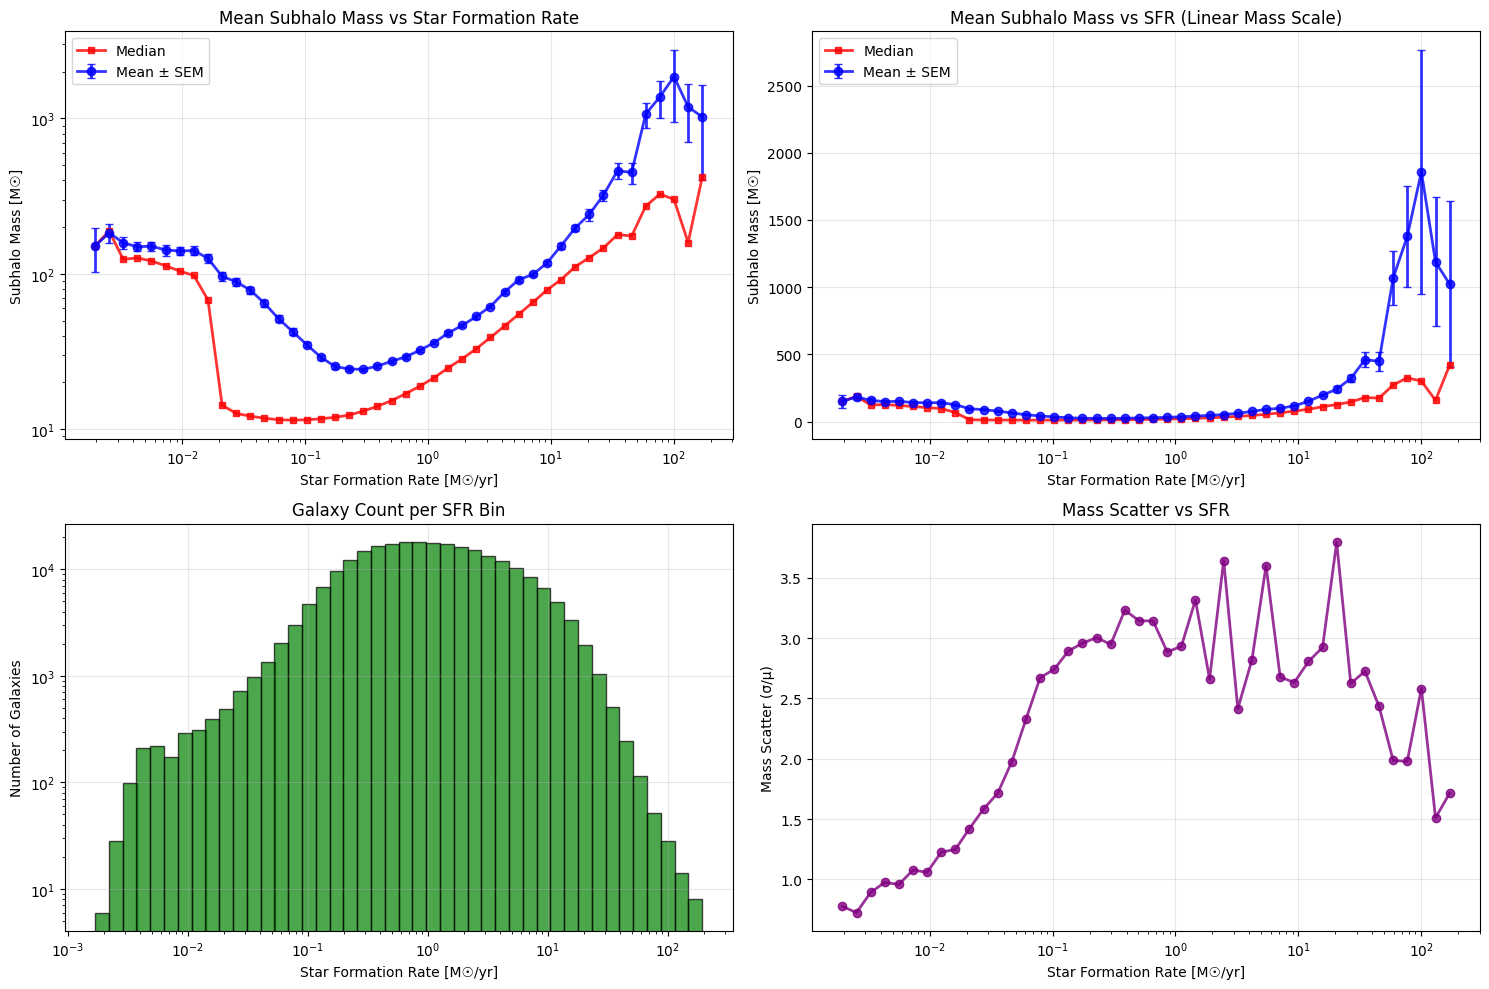


=== Mass-SFR Relationship Statistics ===
Total star-forming galaxies: 257681
SFR range: 1.95e-03 to 1.71e+02 M☉/yr
Mass range: 2.43e+01 to 1.86e+03 M☉
Log-log correlation coefficient: 0.468 (p = 1.34e-03)
Power law fit: M ∝ SFR^0.16 ± 0.05
R² = 0.219, p = 1.34e-03
Normalization: log₁₀(M/M☉) = 2.08 + 0.16 × log₁₀(SFR)


In [5]:
# Mass cutoff at 10 solar masses (M☉)
print("\n" + "="*60)
print("Running analysis with mass cutoff at 10 M☉:")
results_mass_cut_10M = analyzer.run_analysis(
    n_bins=50,          # Number of SFR bins
    log_bins=True,      # Logarithmic SFR binning
    mass_min=10.0,      # Mass cutoff: only galaxies with M > 10 M☉
    save_path='mass_sfr_analysis_mass_cut_10M.png'
)

Loaded 14485709 galaxies

=== Data Analysis ===
SFR statistics:
  Total objects: 14485709
  Star-forming objects (SFR > 0): 576947
  Fraction star-forming: 0.040
  SFR range: 7.87e-04 to 5.92e+01
  SFR median: 4.94e-02
  SFR mean: 2.97e-01

Mass statistics (star-forming galaxies only):
  Mass range: 1.21e-02 to 8.87e+04
  Mass median: 8.26e+00
  Mass mean: 3.16e+01

Running analysis for z = 0.0 with mass cutoff at 10 M☉:
=== Mean Subhalo Mass vs SFR Analysis ===
Applied mass cut > 1.00e+01: 244361 galaxies remaining

Binning results:
  Total star-forming galaxies: 244361
  SFR bins with data: 45/50
  SFR range: 1.73e-03 to 3.38e+01
Figure saved to: mass_sfr_analysis_z0_mass_cut_10M.png


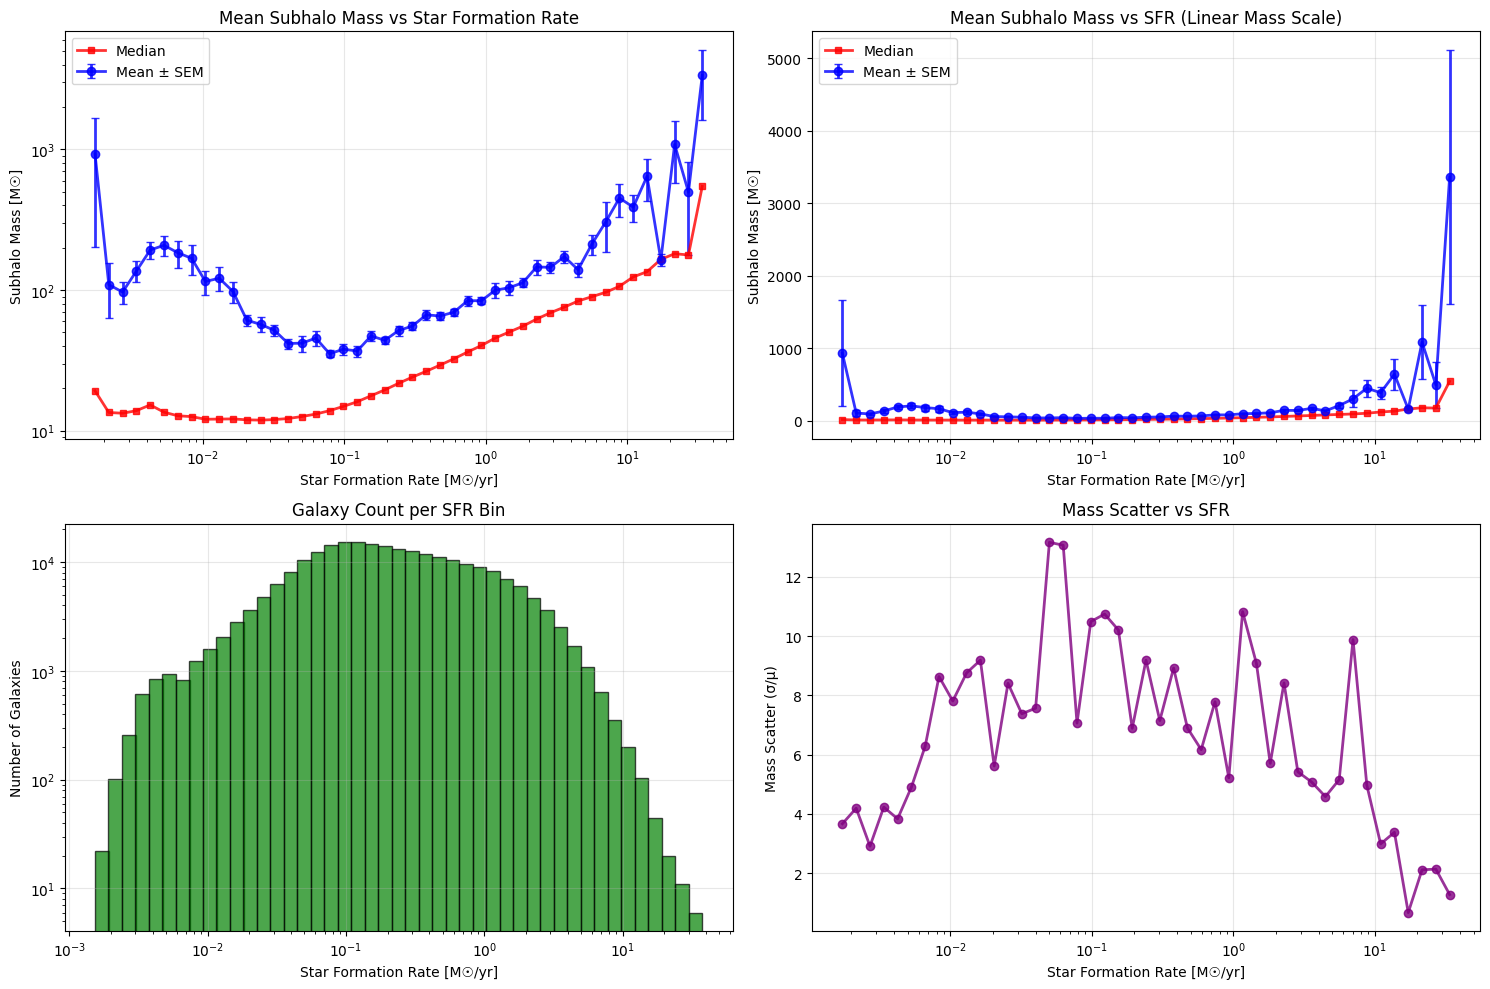


=== Mass-SFR Relationship Statistics ===
Total star-forming galaxies: 244361
SFR range: 1.73e-03 to 3.38e+01 M☉/yr
Mass range: 3.52e+01 to 3.36e+03 M☉
Log-log correlation coefficient: 0.410 (p = 5.21e-03)
Power law fit: M ∝ SFR^0.14 ± 0.05
R² = 0.168, p = 5.21e-03
Normalization: log₁₀(M/M☉) = 2.18 + 0.14 × log₁₀(SFR)
Loaded 17120875 galaxies

=== Data Analysis ===
SFR statistics:
  Total objects: 17120875
  Star-forming objects (SFR > 0): 1293573
  Fraction star-forming: 0.076
  SFR range: 7.71e-04 to 4.31e+02
  SFR median: 3.01e-02
  SFR mean: 6.46e-01

Mass statistics (star-forming galaxies only):
  Mass range: 1.25e-02 to 3.00e+04
  Mass median: 3.31e+00
  Mass mean: 1.33e+01

Running analysis for z = 1.0 with mass cutoff at 10 M☉:
=== Mean Subhalo Mass vs SFR Analysis ===
Applied mass cut > 1.00e+01: 257681 galaxies remaining

Binning results:
  Total star-forming galaxies: 257681
  SFR bins with data: 44/50
  SFR range: 1.95e-03 to 1.71e+02
Figure saved to: mass_sfr_analysis_z05_

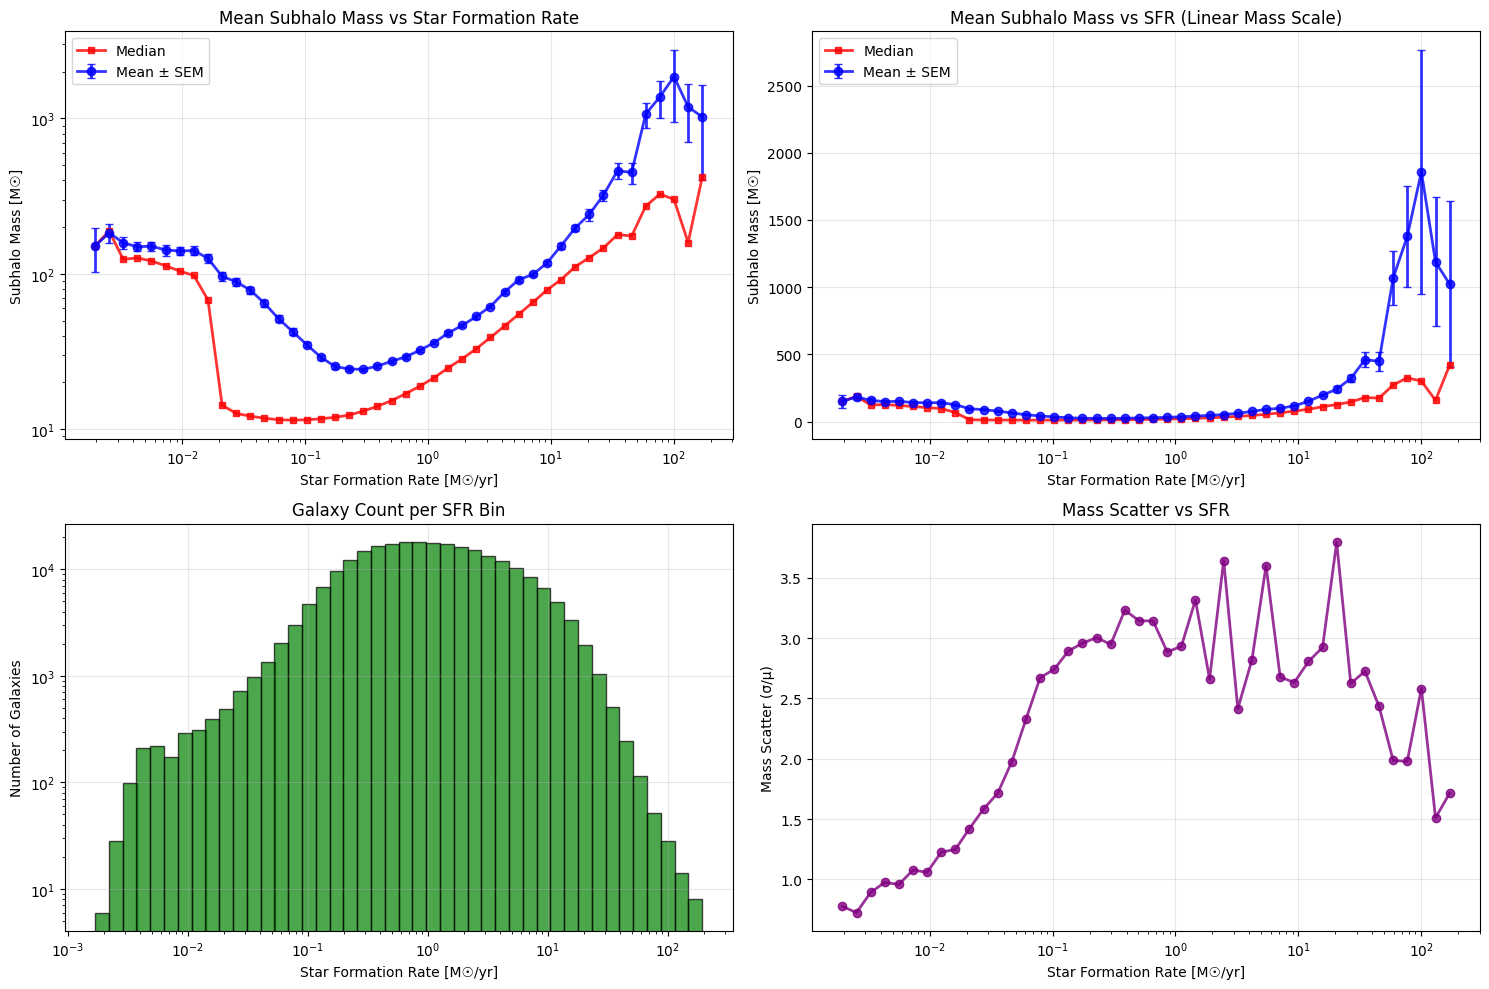


=== Mass-SFR Relationship Statistics ===
Total star-forming galaxies: 257681
SFR range: 1.95e-03 to 1.71e+02 M☉/yr
Mass range: 2.43e+01 to 1.86e+03 M☉
Log-log correlation coefficient: 0.468 (p = 1.34e-03)
Power law fit: M ∝ SFR^0.16 ± 0.05
R² = 0.219, p = 1.34e-03
Normalization: log₁₀(M/M☉) = 2.08 + 0.16 × log₁₀(SFR)


In [7]:
# for different redshifts, we can modify the file path to point to the appropriate snapshot
# Example for redshift z = 0.0
file_path_z0 = '/gpfs/nchugh/groupcat_data/pickle_output/subhalos_snap_99.pkl'
# Initialize the analyzer for z = 0.0
analyzer_z0 = MassSFRAnalyzer(file_path_z0)
# Run analysis for z = 0.0 with mass cutoff at 1 M☉
print("\n" + "="*60)
print("Running analysis for z = 0.0 with mass cutoff at 10 M☉:")
results_z0_mass_cut = analyzer_z0.run_analysis(
    n_bins=50,          # Number of SFR bins
    log_bins=True,      # Logarithmic SFR binning
    mass_min=10.0,      # Mass cutoff: only galaxies with M > 10 M☉
    save_path='mass_sfr_analysis_z0_mass_cut_10M.png'
)

# for redshift z = 1.0
file_path_z05 = '/gpfs/nchugh/groupcat_data/pickle_output/subhalos_snap_50.pkl'
# Initialize the analyzer for z = 1.0
analyzer_z05 = MassSFRAnalyzer(file_path_z05)
# Run analysis for z = 1.0 with mass cutoff at 10 M☉
print("\n" + "="*60)
print("Running analysis for z = 1.0 with mass cutoff at 10 M☉:")
results_z05_mass_cut = analyzer_z05.run_analysis(
    n_bins=50,          # Number of SFR bins
    log_bins=True,      # Logarithmic SFR binning
    mass_min=10.0,      # Mass cutoff: only galaxies with M > 10 M☉
    save_path='mass_sfr_analysis_z05_mass_cut_10M.png'
)